# 안개 발생 진단 분류 모델 데이터셋 EDA

## 1. 데이터 설명

- 컬럼

    - `Year` : 년도
    - `Month` : 월
    - `Day` : 일
    - `Time` : 시간 (0 ~ 23)
    - `Minute` : 분 (10분 단위)
    - `STN_ID` : 지점 번호
    - `WS10(deg)` : 10분 평균 풍향, 단위: deg
    - `WS10(m/s)` : 10분 평균 풍속, 단위: m/s
    - `TA` : 1분 평균 기온 10분 주기, 단위: C
    - `RE` : 강수 유무 (0:무강수, 1:강수)
    - `HM` : 1분 평균 상대 습도 10분 주기, 단위: %
    - `sun10` : 1분 일사량 10분단위 합계, 단위: MJ
    - `TS` : 1분 평균 지면온도 10분 주기, 단위: C
    - `VIS1` : 1분 평균 시정 10분 주기, 단위: C (VIS1 변수는 시정 구간을 알 수 있는 변수로 검증 데이터에서는 제외)
    - `class` : 시정 구간

- 시정 계급 기준 (비고: 안개의 기준)

    - `1` : 0 < 시정 < 200
    - `2` : 200 <= 시정 < 500
    - `3` : 500 <= 시정 < 1000
    - `4` : 1000 <= 시정


## 2. 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib import rcParams

import os
import pickle
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings(action='ignore')

# pd.set_option("float_format", "{:.4f}".format)
pd.set_option("display.max_columns", None)

In [2]:
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

### 2-1 로컬 디렉토리 경로

In [68]:
# 작업 디렉토리 변경 (로컬 디렉토리에서 작업시 실행)

def get_local_path(train_dataset_name, test_dataset_name):

    # 작업 디렉토리 origin_dir에 선언
    origin_dir = os.getcwd()

    # ".." : 상위 디렉토리로 이동
    os.chdir("..")

    # 상위 디렉토리에 fog_data가 없다면 fog_data 폴더 생성
    # (이미 폴더 있어도 exist_ok=True면 넘어감)
    os.makedirs("fog_data", exist_ok=True)

    # train/test 데이터셋 경로 잡아준다
    train_path = os.path.join(os.getcwd(), "fog_data", train_dataset_name)
    test_path = os.path.join(os.getcwd(), "fog_data", test_dataset_name)

    # 운영체제가 윈도우일 경우, "\\"를 "/"로 바꿔줘야 한다
    if os.name == "nt":
        train_path = train_path.replace("\\", "/")
        test_path = test_path.replace("\\", "/")

    # origin_dir로 경로 다시 변경 (초기화)
    os.chdir(origin_dir)

    return train_path, test_path

In [69]:
train_path, test_path = get_local_path("fog_train.csv", "fog_test.csv")

### 2-2. colab 디렉토리 경로 (colab 작업시)

In [5]:
# # 구글 드라이브 파일 접근
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
# # colab 파일 경로 생성 함수
# # colab에서 작업시 주석 풀고 실행

# def get_colab_path(train_dataset_name, test_dataset_name):

#     fog_folder = "drive/MyDrive/weather_bigdata/fog_data"
#     os.makedirs(fog_folder, exist_ok=True)

#     # train/test 데이터셋 경로 잡아준다
#     train_path = os.path.join(os.getcwd(), fog_folder, train_dataset_name)
#     test_path = os.path.join(os.getcwd(), fog_folder, test_dataset_name)

#     return train_path, test_path

In [7]:
# train_path, test_path = get_colab_path("fog_train.csv", "fog_test.csv")

In [70]:
train_df = pd.read_csv(train_path, index_col=0).rename(columns=lambda x: x.split('.')[1]).reset_index(drop=True)
test_df = pd.read_csv(test_path, index_col=0).rename(columns=lambda x: x.split('.')[1]).reset_index(drop=True)

In [71]:
train_df.head(3)

year  month  day  time  minute stn_id  ws10_deg  ws10_ms   ta   re    hm  \
0    I      1    1     0      10     AA       0.0      0.0 -6.4  0.0  38.9   
1    I      1    1     0      20     AA       0.0      0.0 -6.3  0.0  37.9   
2    I      1    1     0      30     AA       0.0      0.0 -6.3  0.0  40.0   

   sun10   ts   vis1  class  
0    0.0 -2.8  20000      4  
1    0.0 -2.7  20000      4  
2    0.0 -2.6  20000      4

In [72]:
test_df.head(3)

year  month  day  time  minute stn_id  ws10_deg  ws10_ms   ta   re    hm  \
0    L      1    1     0       0     AI     329.5      0.6 -2.5  0.0  87.5   
1    L      1    1     0      10     AI     321.8      1.2 -2.5  0.0  88.2   
2    L      1    1     0      20     AI       0.4      0.4 -2.5  0.0  88.6   

   sun10   ts  class  
0    0.0 -1.6    NaN  
1    0.0 -1.6    NaN  
2    0.0 -1.7    NaN

In [73]:
train_df[train_df.duplicated()]

Empty DataFrame
Columns: [year, month, day, time, minute, stn_id, ws10_deg, ws10_ms, ta, re, hm, sun10, ts, vis1, class]
Index: []

In [74]:
test_df[test_df.duplicated()]

Empty DataFrame
Columns: [year, month, day, time, minute, stn_id, ws10_deg, ws10_ms, ta, re, hm, sun10, ts, class]
Index: []

## 3. Preprocessing

In [75]:
# train, test 데이터셋에서 -99, -99.9 포함한 컬럼 동일하기 때문에 같이 변수로 선언
cols_99 = train_df.columns[train_df.isin([-99]).any()].tolist()
cols_99_9 = train_df.columns[train_df.isin([-99.9]).any()].tolist()

In [76]:
print("Train 데이터셋 -99인 값 포함 컬럼 :", cols_99)
print("Train 데이터셋 -99.9인 값 포함 컬럼 :", cols_99_9)

Train 데이터셋 -99인 값 포함 컬럼 : ['vis1', 'class']
Train 데이터셋 -99.9인 값 포함 컬럼 : ['ws10_deg', 'ws10_ms', 'ta', 're', 'hm', 'sun10', 'ts']


### 3-1. 데이터셋 분리 (Train / Validation)

In [77]:
# train / validation 분리에 앞서, target 변수의 결측치를 미리 제거
def drop_nan_in_target(df, col):
    df[col] = df[col].replace({-99:np.nan, -99.9:np.nan})
    dropped = df.dropna()
    return dropped

In [78]:
train_df = drop_nan_in_target(train_df, "class")

In [79]:
train_df, val_df = train_test_split(train_df, random_state=42, train_size=0.75, stratify=train_df["class"])

In [80]:
train_df.shape, val_df.shape


((2350457, 15), (783486, 15))

In [81]:
train_df

year  month  day  time  minute stn_id  ws10_deg  ws10_ms    ta   re  \
1593146    J      4    4    15      40     BC     112.4      2.2  10.3  0.0   
2629179    K     12   20     8       0     BB     328.9      0.7 -10.0  0.0   
543067     I      4   21     9       0     BC     273.6      4.8  10.1  0.0   
855552     I      3   26    10      50     DC     158.2      3.1  18.1  0.0   
2448696    K      7   14    23      30     AG     238.0      0.9  24.0  0.0   
...      ...    ...  ...   ...     ...    ...       ...      ...   ...  ...   
1171997    J      3   31     0      10     AC     120.0      1.2  10.4  0.0   
770833     I      8   17     2      40     DA     239.4      3.4  25.4  0.0   
256588     I     11   13    21      30     AE     184.6      0.7  11.4  0.0   
565557     I      9   24    13      20     BC      80.4      1.9  22.1  0.0   
1584719    J      2    5     3      10     BC     316.2      1.5  -4.2  0.0   

           hm  sun10    ts   vis1  class  
1593146  59.3   0.14  13.8  20000    4.0  
2629179  80.8   0.00 -99.9  11074    4.0  
543067   54.4   0.31  18.3  20000    4.0  
855552   47.0   0.22  20.1  50100    4.0  
2448696  81.8   0.00  24.3  15733    4.0  
...       ...    ...   ...    ...    ...  
1171997  64.0   0.00   7.2  20000    4.0  
770833   92.7   0.00  25.3   4166    4.0  
256588   83.4   0.00   5.5   4350    4.0  
565557   63.1   0.25  29.5  20000    4.0  
1584719  42.9   0.00 -99.9  20000    4.0  

[2350457 rows x 15 columns]

### 3-2. 컬럼 수정 및 제거 함수

In [19]:
# 컬럼 수정 및 제거 함수
def modify_columns(train_df, val_df, test_df):

    # stn_id 수정 : A, B, C, D, E로 수정
    train_df["stn_id"] = train_df["stn_id"].apply(lambda x: x[0])
    val_df["stn_id"] = val_df["stn_id"].apply(lambda x: x[0])
    test_df["stn_id"] = test_df["stn_id"].apply(lambda x: x[0])

    # year, month, day, time, minute, 컬럼 drop
    # train_df.drop(columns=["year", "month", "day", "time", "minute", "vis1"], inplace=True)
    # test_df.drop(columns=["year", "month", "day", "time", "minute"], inplace=True)

    # hm = 0인 데이터 index 찾아서 drop
    hm_zero_idx = train_df[train_df['hm'] == 0].index
    train_df.drop(hm_zero_idx, inplace=True)

    # day, minute 컬럼 제거
    train_df.drop(columns=["day", "minute"], inplace=True)
    val_df.drop(columns=["day", "minute"], inplace=True)
    test_df.drop(columns=["day", "minute"], inplace=True)

    return train_df, val_df, test_df

In [20]:
train_df, val_df, test_df = modify_columns(train_df, val_df, test_df)

### 3-3. 안개 여부 컬럼 생성 함수
- `class` = 4 : 안개 X (0)
- `class` <= 3 : 안개 O (1)

In [21]:
def is_fog(df, column):
    df["is_fog"] = df[column].apply(lambda x: 0 if x > 3 else 1)
    return df

In [22]:
train_df = is_fog(train_df, "class")
val_df = is_fog(val_df, "class")
test_df = is_fog(test_df, "class")


In [23]:
# class 컬럼 값 count
class_cnt = train_df["class"].value_counts().to_frame()

# class 컬럼 값 비율
class_pct = train_df["class"].value_counts(normalize=True).to_frame()

# 개수, 비율 concat
pd.concat([class_cnt, class_pct], axis=1).sort_index()

count  proportion
class                     
1.0       5899    0.002510
2.0       9066    0.003857
3.0       9135    0.003886
4.0    2326356    0.989747

### 3-4. 이슬점

#### 3-4-1. 이슬점 생성 함수

In [24]:
def calculate_dew_point(T, RH):
    # 이슬점 생성 함수
    # T : 기온, RH : 상대 습도

    # b = 17.27
    # c = 237.7
    b = 17.62
    c = 234.12

    gamma = (b * T) / (c + T) + np.log(RH / 100.0)
    dew_point = (c * gamma) / (b - gamma)

    return dew_point

In [25]:
train_df["dew_point"] = calculate_dew_point(train_df['ta'], train_df['hm'])
val_df["dew_point"] = calculate_dew_point(val_df['ta'], val_df['hm'])
test_df["dew_point"] = calculate_dew_point(test_df['ta'], test_df['hm'])

In [26]:
# dew_point가 NaN인 데이터의 hm 확인 → 전부 -99.9 
print("train_df dew_point가 NaN인 데이터의 hm 컬럼 value_counts:", train_df[train_df["dew_point"].isnull()]["hm"].value_counts(), "\n")
print("val_df dew_point가 NaN인 데이터의 hm 컬럼 value_counts:", val_df[val_df["dew_point"].isnull()]["hm"].value_counts(), "\n")
print("test_df dew_point가 NaN인 데이터의 hm 컬럼 value_counts:", test_df[test_df["dew_point"].isnull()]["hm"].value_counts(), "\n")

train_df dew_point가 NaN인 데이터의 hm 컬럼 value_counts: hm
-99.9    907
Name: count, dtype: int64 

val_df dew_point가 NaN인 데이터의 hm 컬럼 value_counts: hm
-99.9    309
Name: count, dtype: int64 

test_df dew_point가 NaN인 데이터의 hm 컬럼 value_counts: hm
-99.9    57
Name: count, dtype: int64 



#### 3-4-2. 이슬점 도달 여부 함수

In [27]:
def diff_ts_dew(df, ts, dew_point):
    # 기온 - 이슬점 <= 0, 이슬점 온도보다 기온이 낮다는 뜻
    df["dew_reached"] = df.apply(lambda x: 1 if (x[ts] - x[dew_point] <= 0) else 0, axis=1)

    return df       

In [28]:
train_df = diff_ts_dew(train_df, "ts", "dew_point")
val_df = diff_ts_dew(val_df, "ts", "dew_point")
test_df = diff_ts_dew(test_df, "ts", "dew_point")

### 3-5. 온도 차이 함수 (기온 - 지표면 온도)

In [29]:
def temp_diff(df):
    df["temp_diff"] = df["ta"] - df["ts"]
    return df

In [30]:
train_df = temp_diff(train_df)
val_df = temp_diff(val_df)
test_df = temp_diff(test_df)

### 3-6. 풍향 수정
- `ws10_deg` 가 360인 것 → 0으로 변경 (일단 미적용)
- `ws10_deg`에 맞게 8방위로 변경

In [31]:
# def switch_wind_degree(df, col):
#     # 풍향 360인 것 0으로 변경
#     df[col] = df[col].apply(lambda x: 0 if x==360 else x)
#     return df

In [32]:
def cardinal_points(df, column):

    # 8방위 : 45도 경계선, 16방위 : 22.5도 경계선
    
    # # ws10_deg 컬럼을 16방위로 환산
    # cardinal_points = ["N", "NNE", "NE", "ENE", "E", "ESE", "SE", "SSE", 
    #                "S", "SSW", "SW", "WSW", "W", "WNW", "NW", "NNW"]

    # val = int((num/45)+.5)
    val = df[column].apply(lambda x: int(x/45+.5))

    # ws10_deg 컬럼을 8방위로 환산
    direction_points = ["N", "NE", "E", "SE", "S", "SW", "W", "NW"]
    

    # 환산한 방위를 반영한 새로운 컬럼 생성
    df["ws10_dir"] = val.apply(lambda x: direction_points[(x % 8)])

    return df

In [33]:
train_df = cardinal_points(train_df, "ws10_deg")
val_df = cardinal_points(val_df, "ws10_deg")
test_df = cardinal_points(test_df, "ws10_deg")

### 3-7. 카테고리컬 변수 생성

In [34]:
def make_categorical(df, col_list):

    # class 컬럼 순서형 변수로 변경
    for column in col_list:
        if column in ["month", "class"]:
            df[column] = pd.Categorical(df[column],
                                        # categories=[1, 2, 3, 4, -99],
                                        categories=np.unique(df[column]),
                                        ordered=True)
        else:
            df[column] = pd.Categorical(df[column],
                                        # categories=[1, 2, 3, 4, -99],
                                        categories=np.unique(df[column]),
                                        ordered=False)
            if column == "re":
                df[column] = df[column].astype("int")

    return df

In [35]:
# 범주형 변수들을 categorical_list에 선언

# month도 순서가 있기 때문에 ordinal
# https://wikidocs.net/161040#ordinal

categorical_list = ["month", "re", "is_fog", "dew_reached", "class"]
train_df = make_categorical(train_df, categorical_list)
val_df = make_categorical(val_df, categorical_list)

In [36]:
# test 데이터셋에는 class 컬럼이 없기 때문에, class 컬럼을 삭제한다
categorical_list.pop()
test_df = make_categorical(test_df, categorical_list)

### 결측치 중간 삭제

In [37]:
train_df_copy = train_df.copy()

def drop_nan(df):
    df['hm'] = df['hm'].replace(0, np.nan)
    df = df.replace({-99:np.nan, -99.9:np.nan})    
    # train_df = train_df.replace({-99:np.nan, -99.9:np.nan})
    # test_df = test_df.replace({-99:np.nan, -99.9:np.nan})
    df.dropna(inplace=True)
    
    return df

In [38]:
train_df_copy = drop_nan(train_df_copy)

### 3-8. 전처리 마친 데이터셋 피클 저장

In [39]:
def pickle_local_path(dataset_name):

    # 작업 디렉토리 origin_dir에 선언
    origin_dir = os.getcwd()

    # ".." : 상위 디렉토리로 이동
    os.chdir("..")

    # 상위 디렉토리에 fog_data가 없다면 fog_data 폴더 생성
    # (이미 폴더 있어도 exist_ok=True면 넘어감)
    os.makedirs("fog_data", exist_ok=True)

    # train/test 데이터셋 경로 잡아준다
    path = os.path.join(os.getcwd(), "fog_data", dataset_name)

    # 운영체제가 윈도우일 경우, "\\"를 "/"로 바꿔줘야 한다
    if os.name == "nt":
        path = path.replace("\\", "/")

    # origin_dir로 경로 다시 변경 (초기화)
    os.chdir(origin_dir)

    return path

In [40]:
train_pkl_path = pickle_local_path("train_checkpoint.pickle")
val_pkl_path = pickle_local_path("val_checkpoint.pickle")
test_pkl_path = pickle_local_path("test_checkpoint.pickle")

In [41]:
# 데이터프레임 train, val, test 저장
with open(train_pkl_path, 'wb') as f:
    pickle.dump(train_df, f)

with open(val_pkl_path, 'wb') as f:
    pickle.dump(val_df, f)

with open(test_pkl_path, 'wb') as f:
    pickle.dump(test_df, f)

## 4. EDA

In [42]:
# 명목형 변수 값 확인
cat_col_names = train_df.select_dtypes(exclude=np.number).columns

for col_name in cat_col_names:
    cat_values = np.unique(train_df[col_name])
    print(f"{col_name}: {cat_values}\n")

year: ['I' 'J' 'K']

month: [ 1  2  3  4  5  6  7  8  9 10 11 12]

stn_id: ['A' 'B' 'C' 'D' 'E']

class: [1. 2. 3. 4.]

is_fog: [0 1]

dew_reached: [0 1]

ws10_dir: ['E' 'N' 'NE' 'NW' 'S' 'SE' 'SW' 'W']



In [43]:
# 수치형 변수 최대, 최소값 확인
num_col_names = train_df.select_dtypes(include=np.number).columns

for col_name in num_col_names:
    print(f"{col_name}: ({train_df[col_name].min()}, {train_df[col_name].max()})")

time: (0, 23)
ws10_deg: (-99.9, 360.0)
ws10_ms: (-99.9, 21.6)
ta: (-99.9, 37.8)
re: (-99, 1)
hm: (-99.9, 100.0)
sun10: (-99.9, 20.83)
ts: (-99.9, 70.1)
vis1: (1, 60525)
dew_point: (-106.84325967115815, 29.83689797028356)
temp_diff: (-146.5, 133.60000000000002)


In [44]:
train_df.describe()

time      ws10_deg       ws10_ms            ta            re  \
count  2.350456e+06  2.350456e+06  2.350456e+06  2.350456e+06  2.350456e+06   
mean   1.150013e+01  1.855465e+02  2.078331e+00  1.334852e+01 -3.535420e-01   
std    6.923302e+00  1.069394e+02  3.790557e+00  1.055100e+01  6.327751e+00   
min    0.000000e+00 -9.990000e+01 -9.990000e+01 -9.990000e+01 -9.900000e+01   
25%    5.000000e+00  8.530000e+01  9.000000e-01  5.500000e+00  0.000000e+00   
50%    1.200000e+01  2.097000e+02  1.800000e+00  1.420000e+01  0.000000e+00   
75%    1.800000e+01  2.770000e+02  3.100000e+00  2.200000e+01  0.000000e+00   
max    2.300000e+01  3.600000e+02  2.160000e+01  3.780000e+01  1.000000e+00   

                 hm         sun10            ts          vis1     dew_point  \
count  2.350456e+06  2.350456e+06  2.350456e+06  2.350456e+06  2.349549e+06   
mean   6.676396e+01 -1.220816e+00  1.287396e+01  1.977669e+04  6.825092e+00   
std    2.125116e+01  1.142744e+01  2.240737e+01  1.198931e+04  1.173617e+01   
min   -9.990000e+01 -9.990000e+01 -9.990000e+01  1.000000e+00 -1.068433e+02   
25%    5.130000e+01  0.000000e+00  5.100000e+00  1.250000e+04 -2.031140e+00   
50%    6.870000e+01  0.000000e+00  1.560000e+01  2.000000e+04  6.955223e+00   
75%    8.470000e+01  1.600000e-01  2.430000e+01  2.000000e+04  1.719653e+01   
max    1.000000e+02  2.083000e+01  7.010000e+01  6.052500e+04  2.983690e+01   

          temp_diff  
count  2.350456e+06  
mean   4.745545e-01  
std    1.619332e+01  
min   -1.465000e+02  
25%   -3.300000e+00  
50%   -6.000000e-01  
75%    1.200000e+00  
max    1.336000e+02

### 4-1. 월별 안개 발생 분포 확인

In [45]:
# 안개가 발생한 것만 필터링하여 fog_yes_df에 선언
fog_yes_df = train_df.groupby(["month"])[["is_fog", "class"]].value_counts().to_frame()

In [46]:
# 월별 안개발생 빈도를 따로 groupby하여, fog_yes_total에 선언
fog_tot_num = train_df[train_df["is_fog"]==1].groupby(["month"])["class"].count().to_frame()
fog_tot_num = fog_tot_num.rename(columns={"class":"tot_cnts"}).reset_index()

In [47]:
,# season_df에서 안개가 낀 데이터만 가져옴
is_fog_df = fog_yes_df.reset_index()[(fog_yes_df.reset_index()["is_fog"] == 1) & (fog_yes_df.reset_index()["class"] != 4)]

# season 별 stn_id의 비율을 구하기 위해 season_fot_tot_num 데이터프레임과 merge
is_fog_df = is_fog_df.merge(fog_tot_num)

is_fog_df["fog_distribution"] = is_fog_df["count"] / is_fog_df["tot_cnts"]

# season, stn_id 컬럼 순으로 정렬
is_fog_df = is_fog_df.sort_values(["month", "class"])

# # proportion을 %로 만들어주고 소수 셋째자리에서 반올림
# is_fog_df["proportion"] = is_fog_df["proportion"].apply(lambda x: np.round(x*100, 2))

is_fog_df["fog_distribution"] = is_fog_df["fog_distribution"].apply(lambda x: np.round(x*100, 2))

In [48]:
is_fog_df

month is_fog class  count  tot_cnts  fog_distribution
2      1      1   1.0    389      1998             19.47
1      1      1   2.0    603      1998             30.18
0      1      1   3.0   1006      1998             50.35
5      2      1   1.0    286      1421             20.13
4      2      1   2.0    372      1421             26.18
3      2      1   3.0    763      1421             53.69
6      3      1   1.0    796      2187             36.40
8      3      1   2.0    693      2187             31.69
7      3      1   3.0    698      2187             31.92
10     4      1   1.0    313       911             34.36
9      4      1   2.0    340       911             37.32
11     4      1   3.0    258       911             28.32
14     5      1   1.0    333      1532             21.74
12     5      1   2.0    606      1532             39.56
13     5      1   3.0    593      1532             38.71
17     6      1   1.0    401      1922             20.86
16     6      1   2.0    698      1922             36.32
15     6      1   3.0    823      1922             42.82
20     7      1   1.0    459      2514             18.26
19     7      1   2.0    939      2514             37.35
18     7      1   3.0   1116      2514             44.39
23     8      1   1.0    350      1942             18.02
22     8      1   2.0    719      1942             37.02
21     8      1   3.0    873      1942             44.95
26     9      1   1.0    668      2724             24.52
24     9      1   2.0   1261      2724             46.29
25     9      1   3.0    795      2724             29.19
29    10      1   1.0    673      2825             23.82
27    10      1   2.0   1392      2825             49.27
28    10      1   3.0    760      2825             26.90
32    11      1   1.0    746      2423             30.79
30    11      1   2.0    878      2423             36.24
31    11      1   3.0    799      2423             32.98
35    12      1   1.0    485      1701             28.51
34    12      1   2.0    565      1701             33.22
33    12      1   3.0    651      1701             38.27

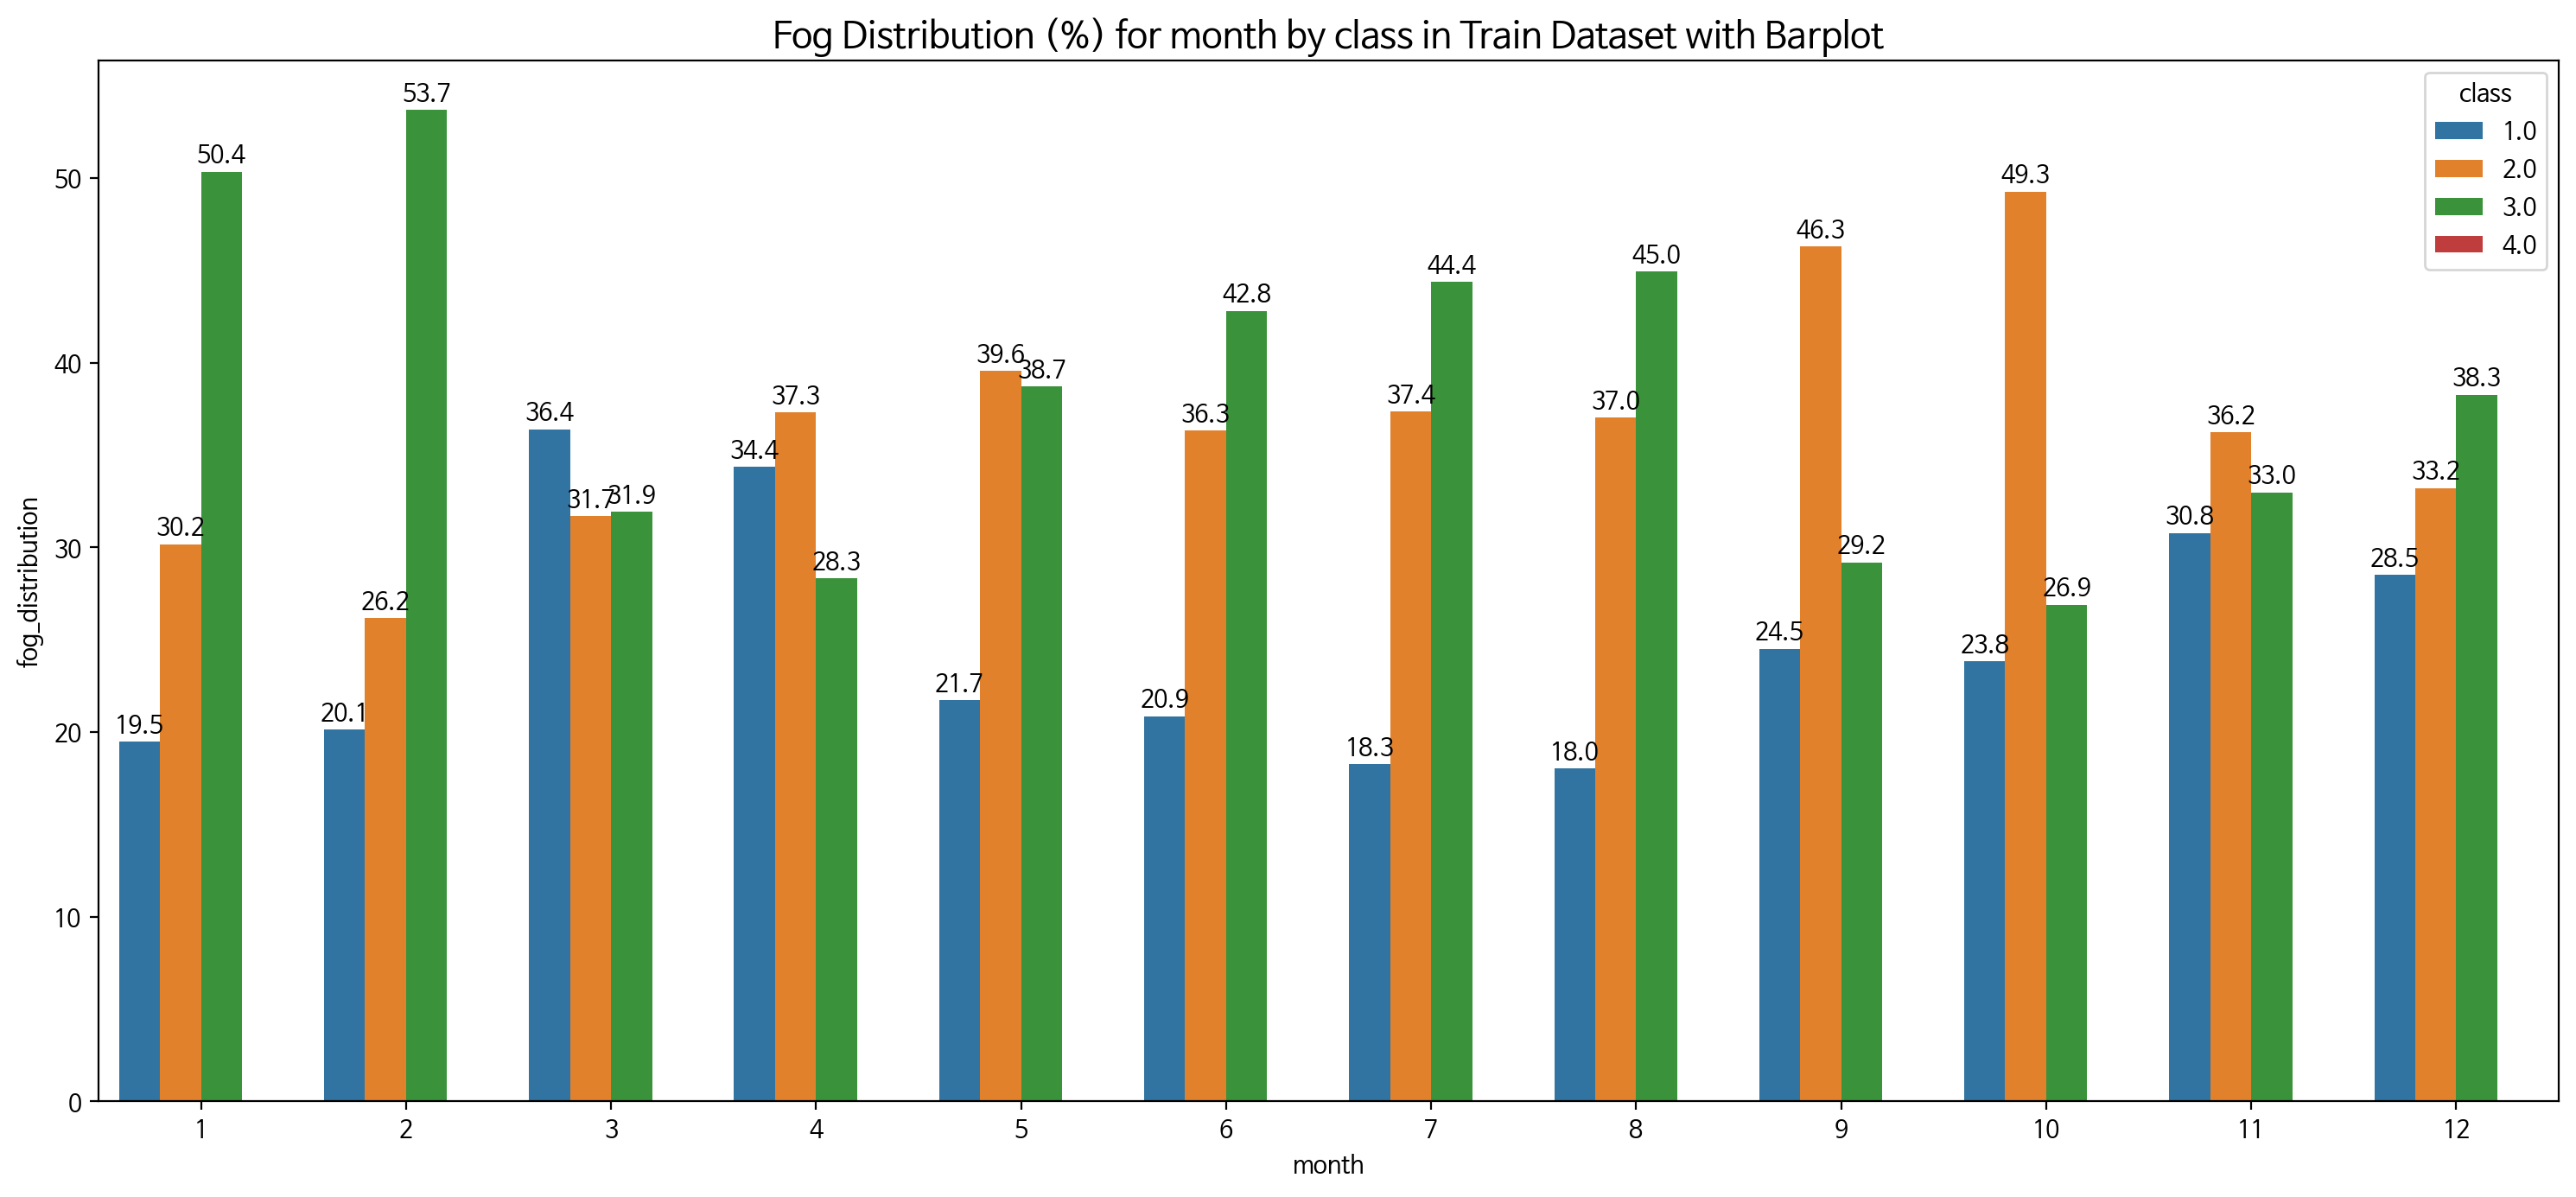

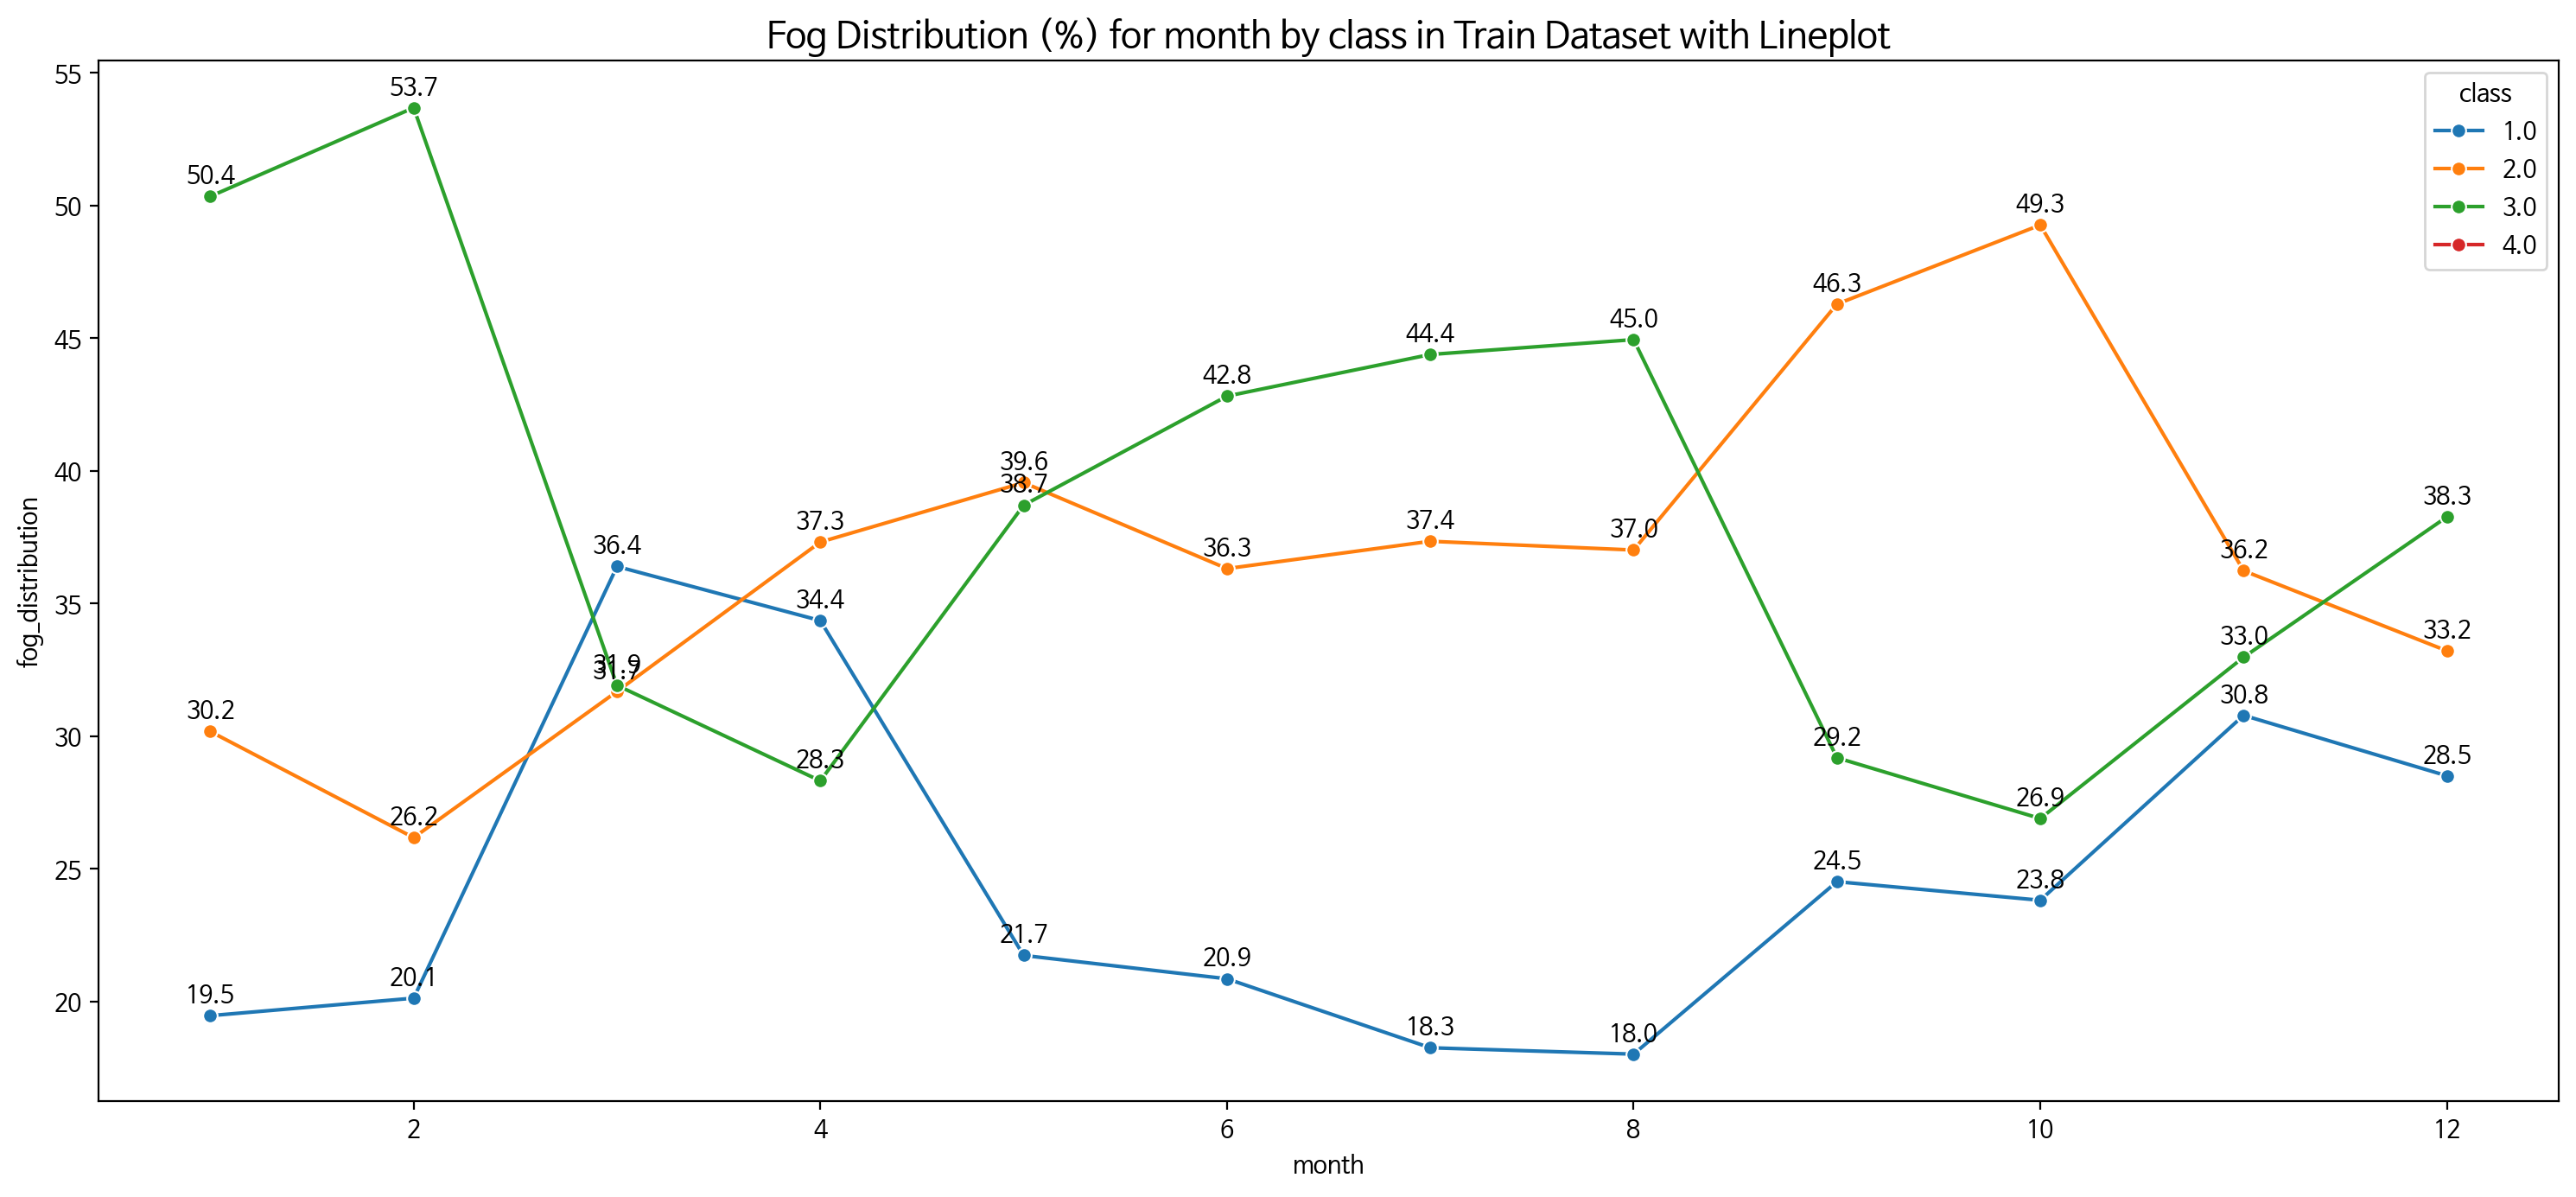

In [49]:
# class=4가 아닌 데이터만 선택
# filtered_data = fog_yes_group[fog_yes_group['class'] != 4]

plt.figure(figsize=(15, 7))

# 막대 그래프 생성
sns_pct = sns.barplot(x="month", 
                      y="fog_distribution", 
                      hue="class", 
                      data=is_fog_df)

# x축 레이블 회전
sns_pct.set_xticklabels(sns_pct.get_xticklabels(), 
                        # rotation=30
                        )

# 막대 그래프 상단에 비율 (%) 표기
# 각 x 좌표별로 높이를 저장
heights_by_x = {}

for bar in sns_pct.patches:
    height = bar.get_height()  # 막대의 높이 가져오기
    if height > 0:  # 높이가 0보다 클 때만 텍스트 추가
        x = bar.get_x() + bar.get_width() / 2  # 텍스트 위치 x좌표

        if x not in heights_by_x:
            heights_by_x[x] = []

        # 이전 높이값이 존재하면, 새로운 텍스트 위치를 조정
        if heights_by_x[x]:
            previous_heights = sorted(heights_by_x[x], reverse=True)
            # 이전 텍스트와 현재 막대 사이의 최소 간격 설정
            offset = height + 0.5
            for prev_height in previous_heights:
                if abs(prev_height - offset) < 0.5:
                    offset = prev_height + 0.5
        else:
            offset = height + 0.5

        plt.text(x,  # 텍스트 위치 x좌표
                 offset,  # 텍스트 위치 y좌표
                 "%.1f" % height,  # 소수점 둘째 자리까지 비율 표시
                 ha="center")  # 가운데 정렬

        heights_by_x[x].append(offset)

# 불필요한 범례 항목 제거
handles, labels = sns_pct.get_legend_handles_labels()
filtered_handles = [handle for handle, label in zip(handles, labels) if label != '4']
filtered_labels = [label for label in labels if label != '4']

# 시각화 제목과 폰트 크기 지정
sns_pct.set_title("Fog Distribution (%) for month by class in Train Dataset with Barplot", fontsize=15)
sns_pct.legend(filtered_handles, filtered_labels, title='class')

plt.tight_layout()
# plt.show()


# lineplot 생성
plt.figure(figsize=(15, 7))

# 라인 플롯 생성
sns_pct = sns.lineplot(x="month", 
                      y="fog_distribution", 
                      hue="class", 
                      data=is_fog_df,
                      marker='o')  # 포인트에 마커 추가

# 라인 플롯의 각 포인트에 값 표시
for line in sns_pct.lines:
    for x, y in zip(line.get_xdata(), line.get_ydata()):
        if y > 0:  # 높이가 0보다 클 때만 텍스트 추가
            plt.text(x, y + 0.5, f"{y:.1f}", ha="center")

# 불필요한 범례 항목 제거
handles, labels = sns_pct.get_legend_handles_labels()
filtered_handles = [handle for handle, label in zip(handles, labels) if label != '4']
filtered_labels = [label for label in labels if label != '4']

# 시각화 제목과 폰트 크기 지정
sns_pct.set_title("Fog Distribution (%) for month by class in Train Dataset with Lineplot", fontsize=15)
sns_pct.legend(filtered_handles, filtered_labels, title='class')

plt.tight_layout()
plt.show()



#### 4-1-1. 결론
- 계절별로 안개 발생 class가 다르게 나타났다 <br>
 <br>
    - 봄 (3-5) : 비교적 고른 분포 
     
    - 여름 (6-8) : class 2, 3이 주로 발생  
     
    - 가을 (9-11)
    
        - class 2가 주로 발생
        - 여름에 비해 class 1도 증가
        - class=3은 여름에 비해 대폭 감소 
     
     - 겨울 (12-2)
        - 가을에 비해, 다시 class 3이 증가
        - class 1, 2는 다시 감소하는 추세

### 4-2. 월별, 관측소별 안개 발생 빈도 분포

In [50]:
# 월별, 관측소별 안개 유무 카운팅
month_df = train_df.groupby(["month", "stn_id"])["is_fog"].value_counts().to_frame()

In [51]:
# 월별 안개가 낀 빈도수 계산하여 month_fog_tot_num에 선언
month_fog_tot_num = train_df[train_df["is_fog"]==1].groupby(["month"])["stn_id"].count().to_frame()
month_fog_tot_num = month_fog_tot_num.rename(columns={"stn_id":"tot_cnts"}).reset_index()

In [52]:
,# month_df에서 안개가 낀 데이터만 가져옴
month_is_fog = month_df.reset_index()[month_df.reset_index()["is_fog"] == 1]

# month 별 stn_id의 비율을 구하기 위해 month_fot_tot_num 데이터프레임과 merge
month_is_fog = month_is_fog.merge(month_fog_tot_num)

month_is_fog["stn_rate"] = month_is_fog["count"] / month_is_fog["tot_cnts"]


# month, stn_id 컬럼 순으로 정렬
month_is_fog = month_is_fog.sort_values(["month", "stn_id"])

month_is_fog["stn_rate"] = month_is_fog["stn_rate"].apply(lambda x: np.round(x*100, 2))

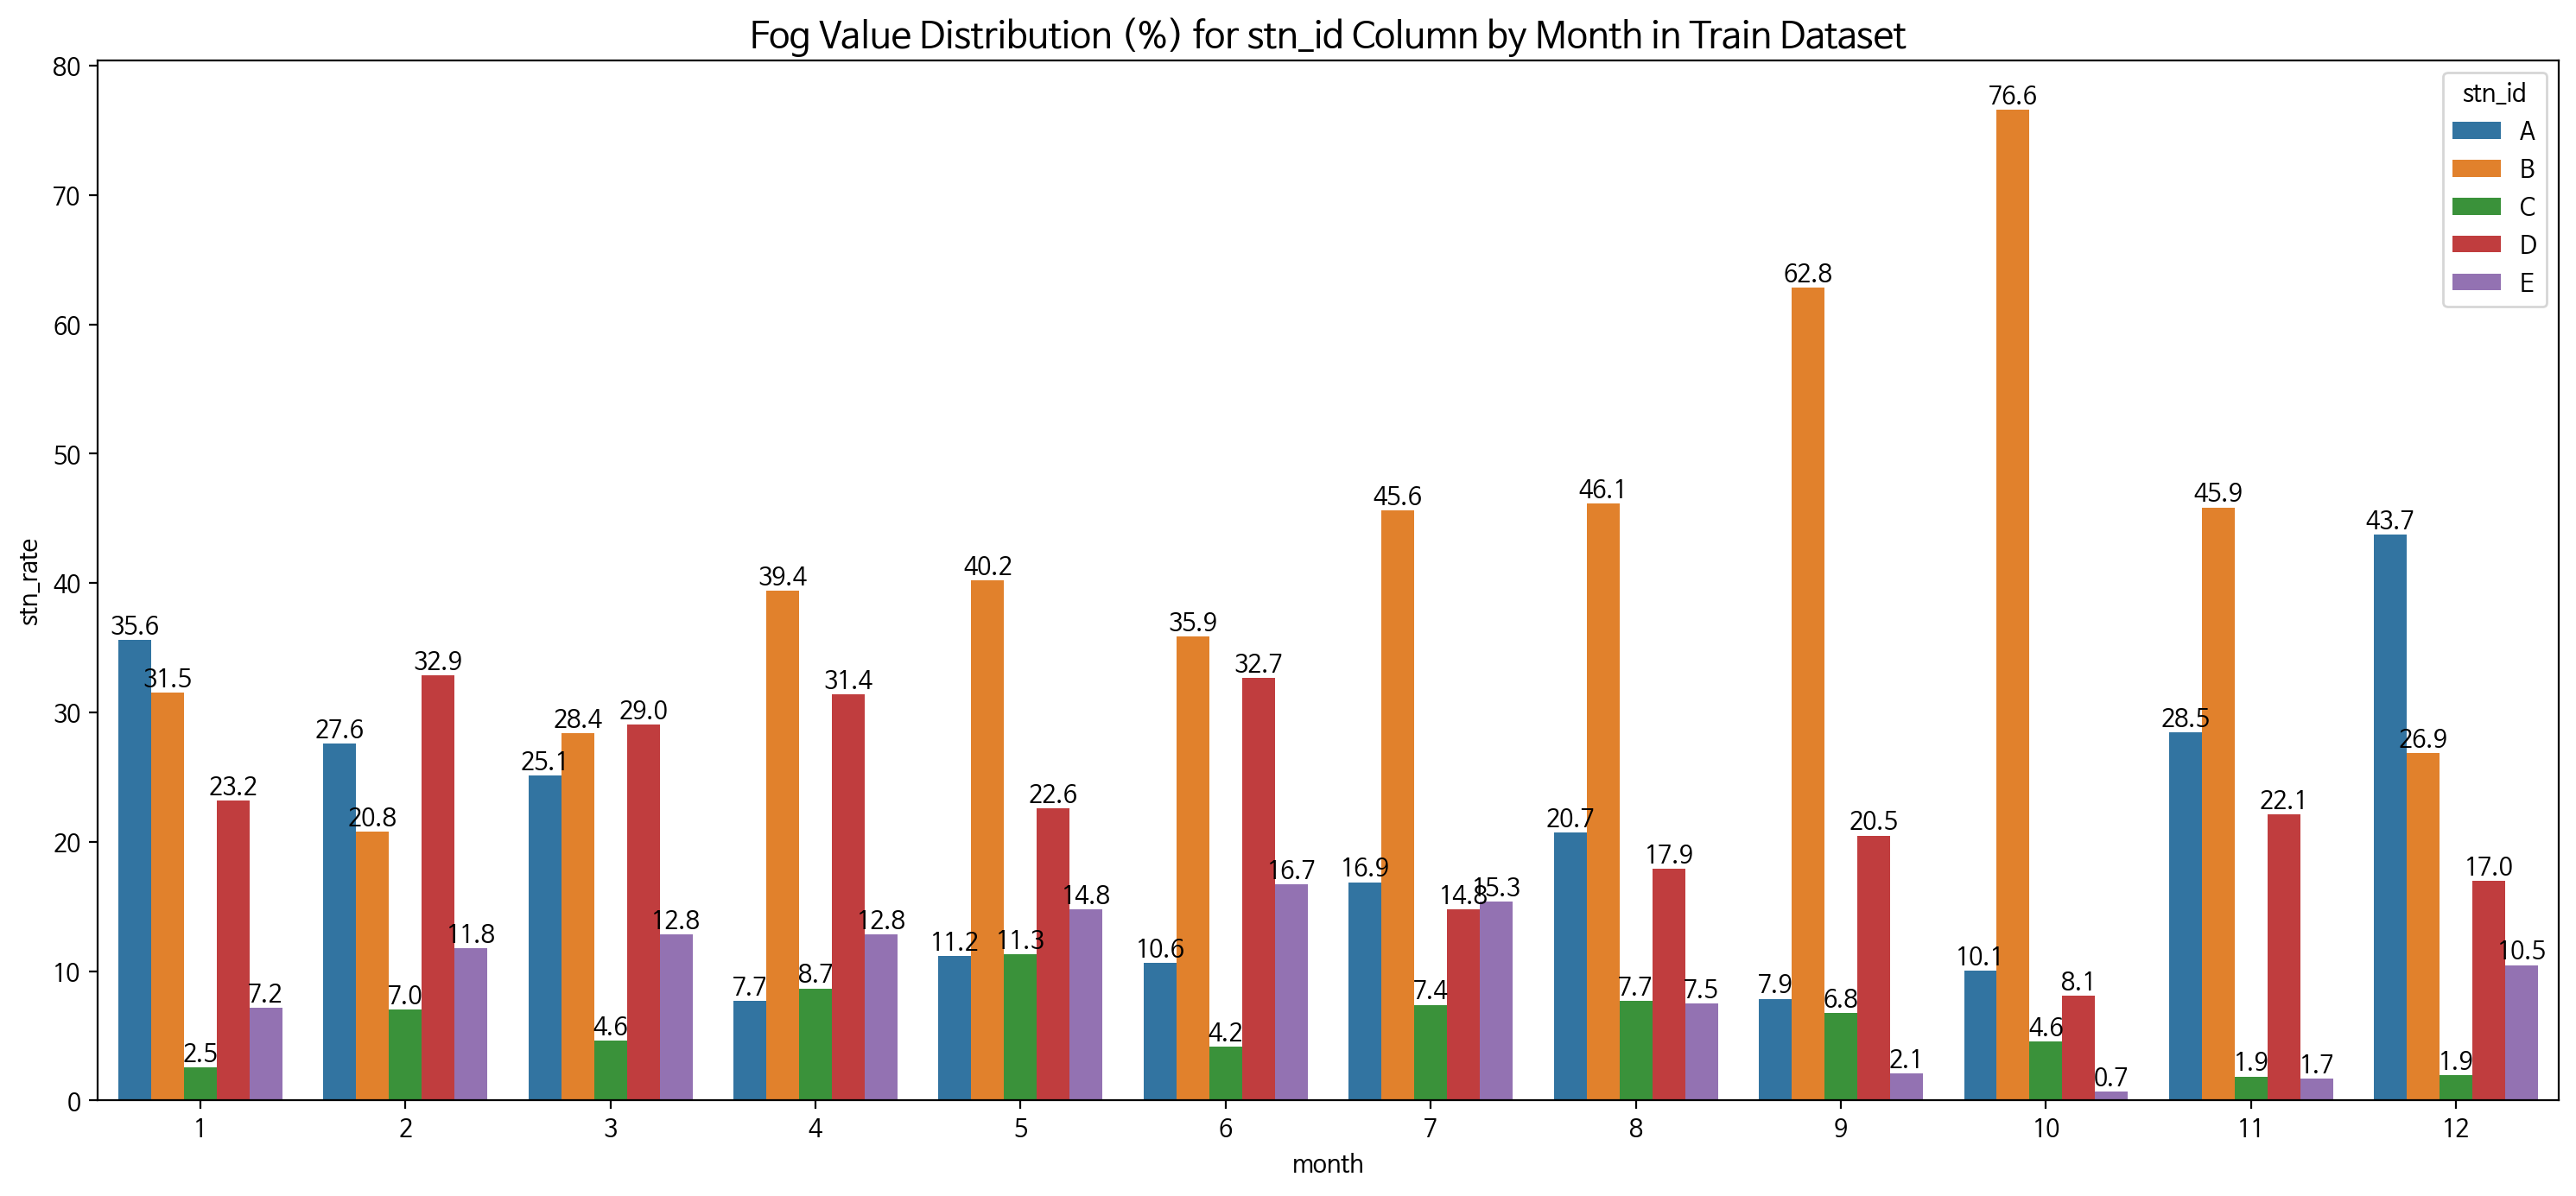

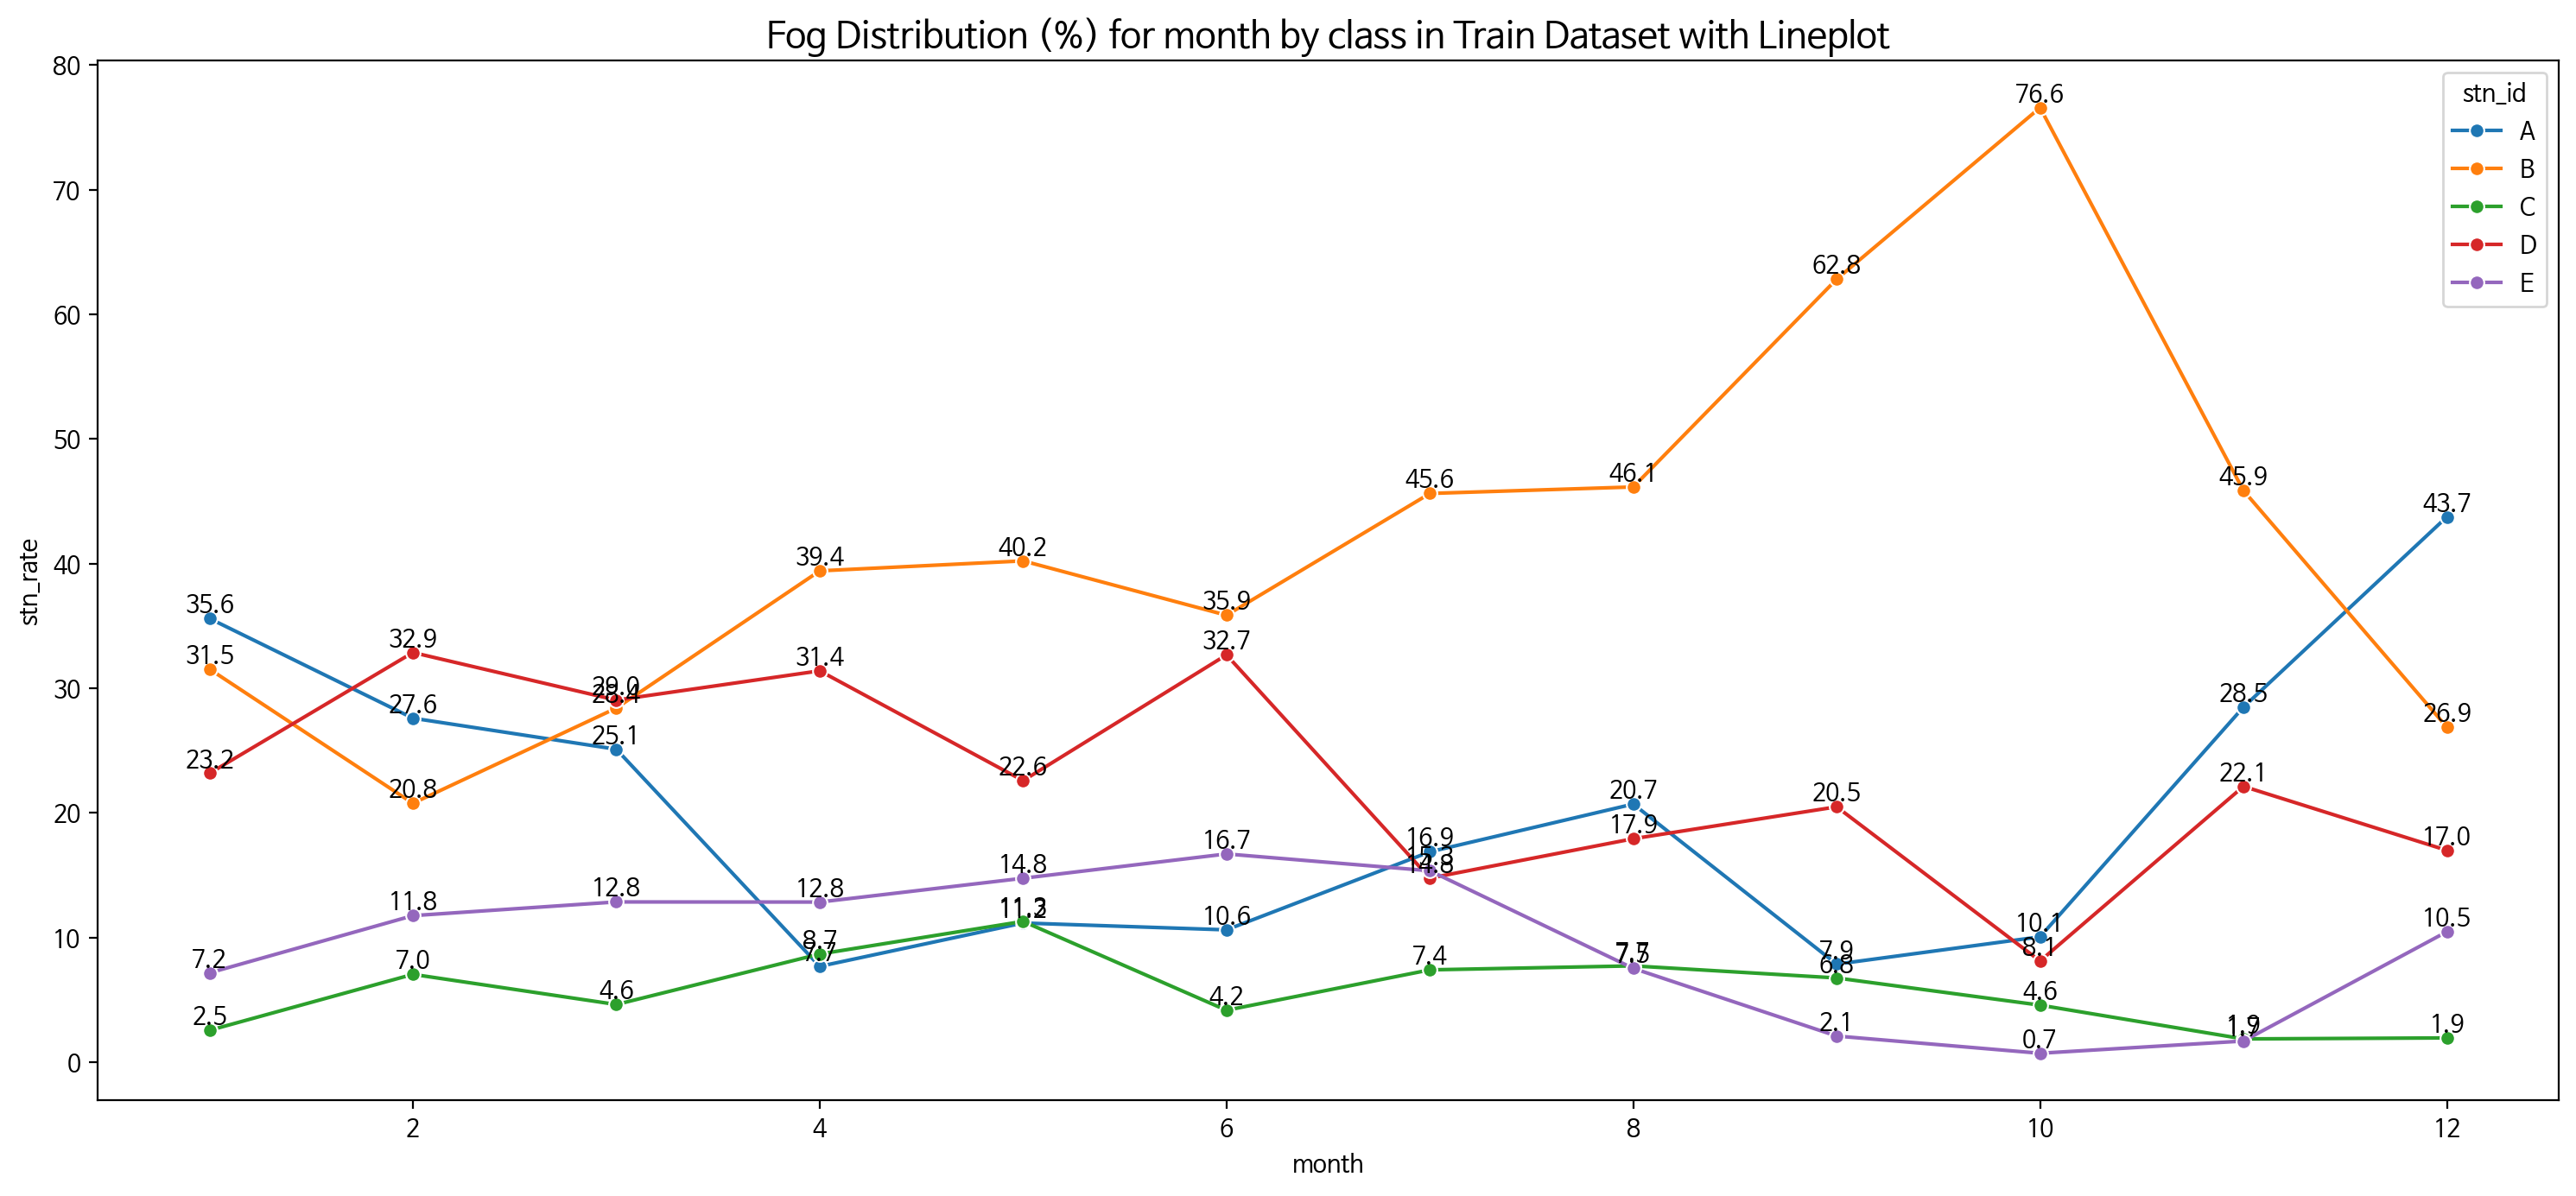

In [53]:
# 결측치 비율 시각화
plt.figure(figsize=(15, 7))

sns_pct = sns.barplot(x="month", 
                      y="stn_rate", 
                      hue="stn_id", 
                      data=month_is_fog)
                    #   data=np.round(is_fog_df * 100, 2).sort_values(["stn_id", "proportion"], ascending=[True, False]))


# sns_pct.set_xticklabels(sns_pct.get_xticklabels(), rotation=30)

# bar 그래프 상단에 비율 (%) 표기
for bar in sns_pct.patches:
    height = bar.get_height()                      # bar의 높이를 가져옴
    if height > 0:                                 # 높이가 0보다 클 때만 텍스트를 추가
        plt.text(bar.get_x() + bar.get_width()/2,  # 글자 위치 x좌표
                 height + 0.5,                   # 글자 위치 y좌표
                 "%.1f" % height,                  # 소수점 셋째 자리까지 비율 표시
                 ha="center")                      # 가운데 정렬


# 시각화 제목 이름, 폰트 크기 지정
sns_pct.set_title("Fog Value Distribution (%) for stn_id Column by Month in Train Dataset", fontsize=15)
plt.tight_layout()
# plt.show()


# lineplot 생성
plt.figure(figsize=(15, 7))

# 라인 플롯 생성
sns_pct = sns.lineplot(x="month", 
                      y="stn_rate", 
                      hue="stn_id", 
                      data=month_is_fog,
                      marker='o')  # 포인트에 마커 추가

# 라인 플롯의 각 포인트에 값 표시
for line in sns_pct.lines:
    for x, y in zip(line.get_xdata(), line.get_ydata()):
        if y > 0:  # 높이가 0보다 클 때만 텍스트 추가
            plt.text(x, y + 0.5, f"{y:.1f}", ha="center")

# 불필요한 범례 항목 제거
handles, labels = sns_pct.get_legend_handles_labels()
filtered_handles = [handle for handle, label in zip(handles, labels) if label != '4']
filtered_labels = [label for label in labels if label != '4']

# 시각화 제목과 폰트 크기 지정
sns_pct.set_title("Fog Distribution (%) for month by class in Train Dataset with Lineplot", fontsize=15)
sns_pct.legend(filtered_handles, filtered_labels, title='stn_id')

plt.tight_layout()
plt.show()

#### 4-2-1. 결론
- 안개 점유율

    - A 관측소 : 3월부터 낮아졌다가 10월부터 증가
    
    - B 관측소 : 8월 이후 높아졌다가 11월부터 2월까지 감소
    - C 관측소 : 전체적으로 저조, 3월부터 5월까지 소폭 증가
    - D 관측소 : 6월부터 8월까지 감소
    - E 관측소 : 7월부터 11월까지 감소, 이후 증가 추세 <br>
<br>
- 가을, 겨울에 내륙에서 안개가 더 많이 발생한다는 점에서, **A**, **B**는 내륙에 위치할 가능성이 크다

    - A, B는 10 ~ 12월 정반대 추세를 보인다
    
    - 11월에 서로 역전된다


### 4-3 이상치 확인 

#### 4-3-1. 이상치 시각화 (temp_diff 컬럼)

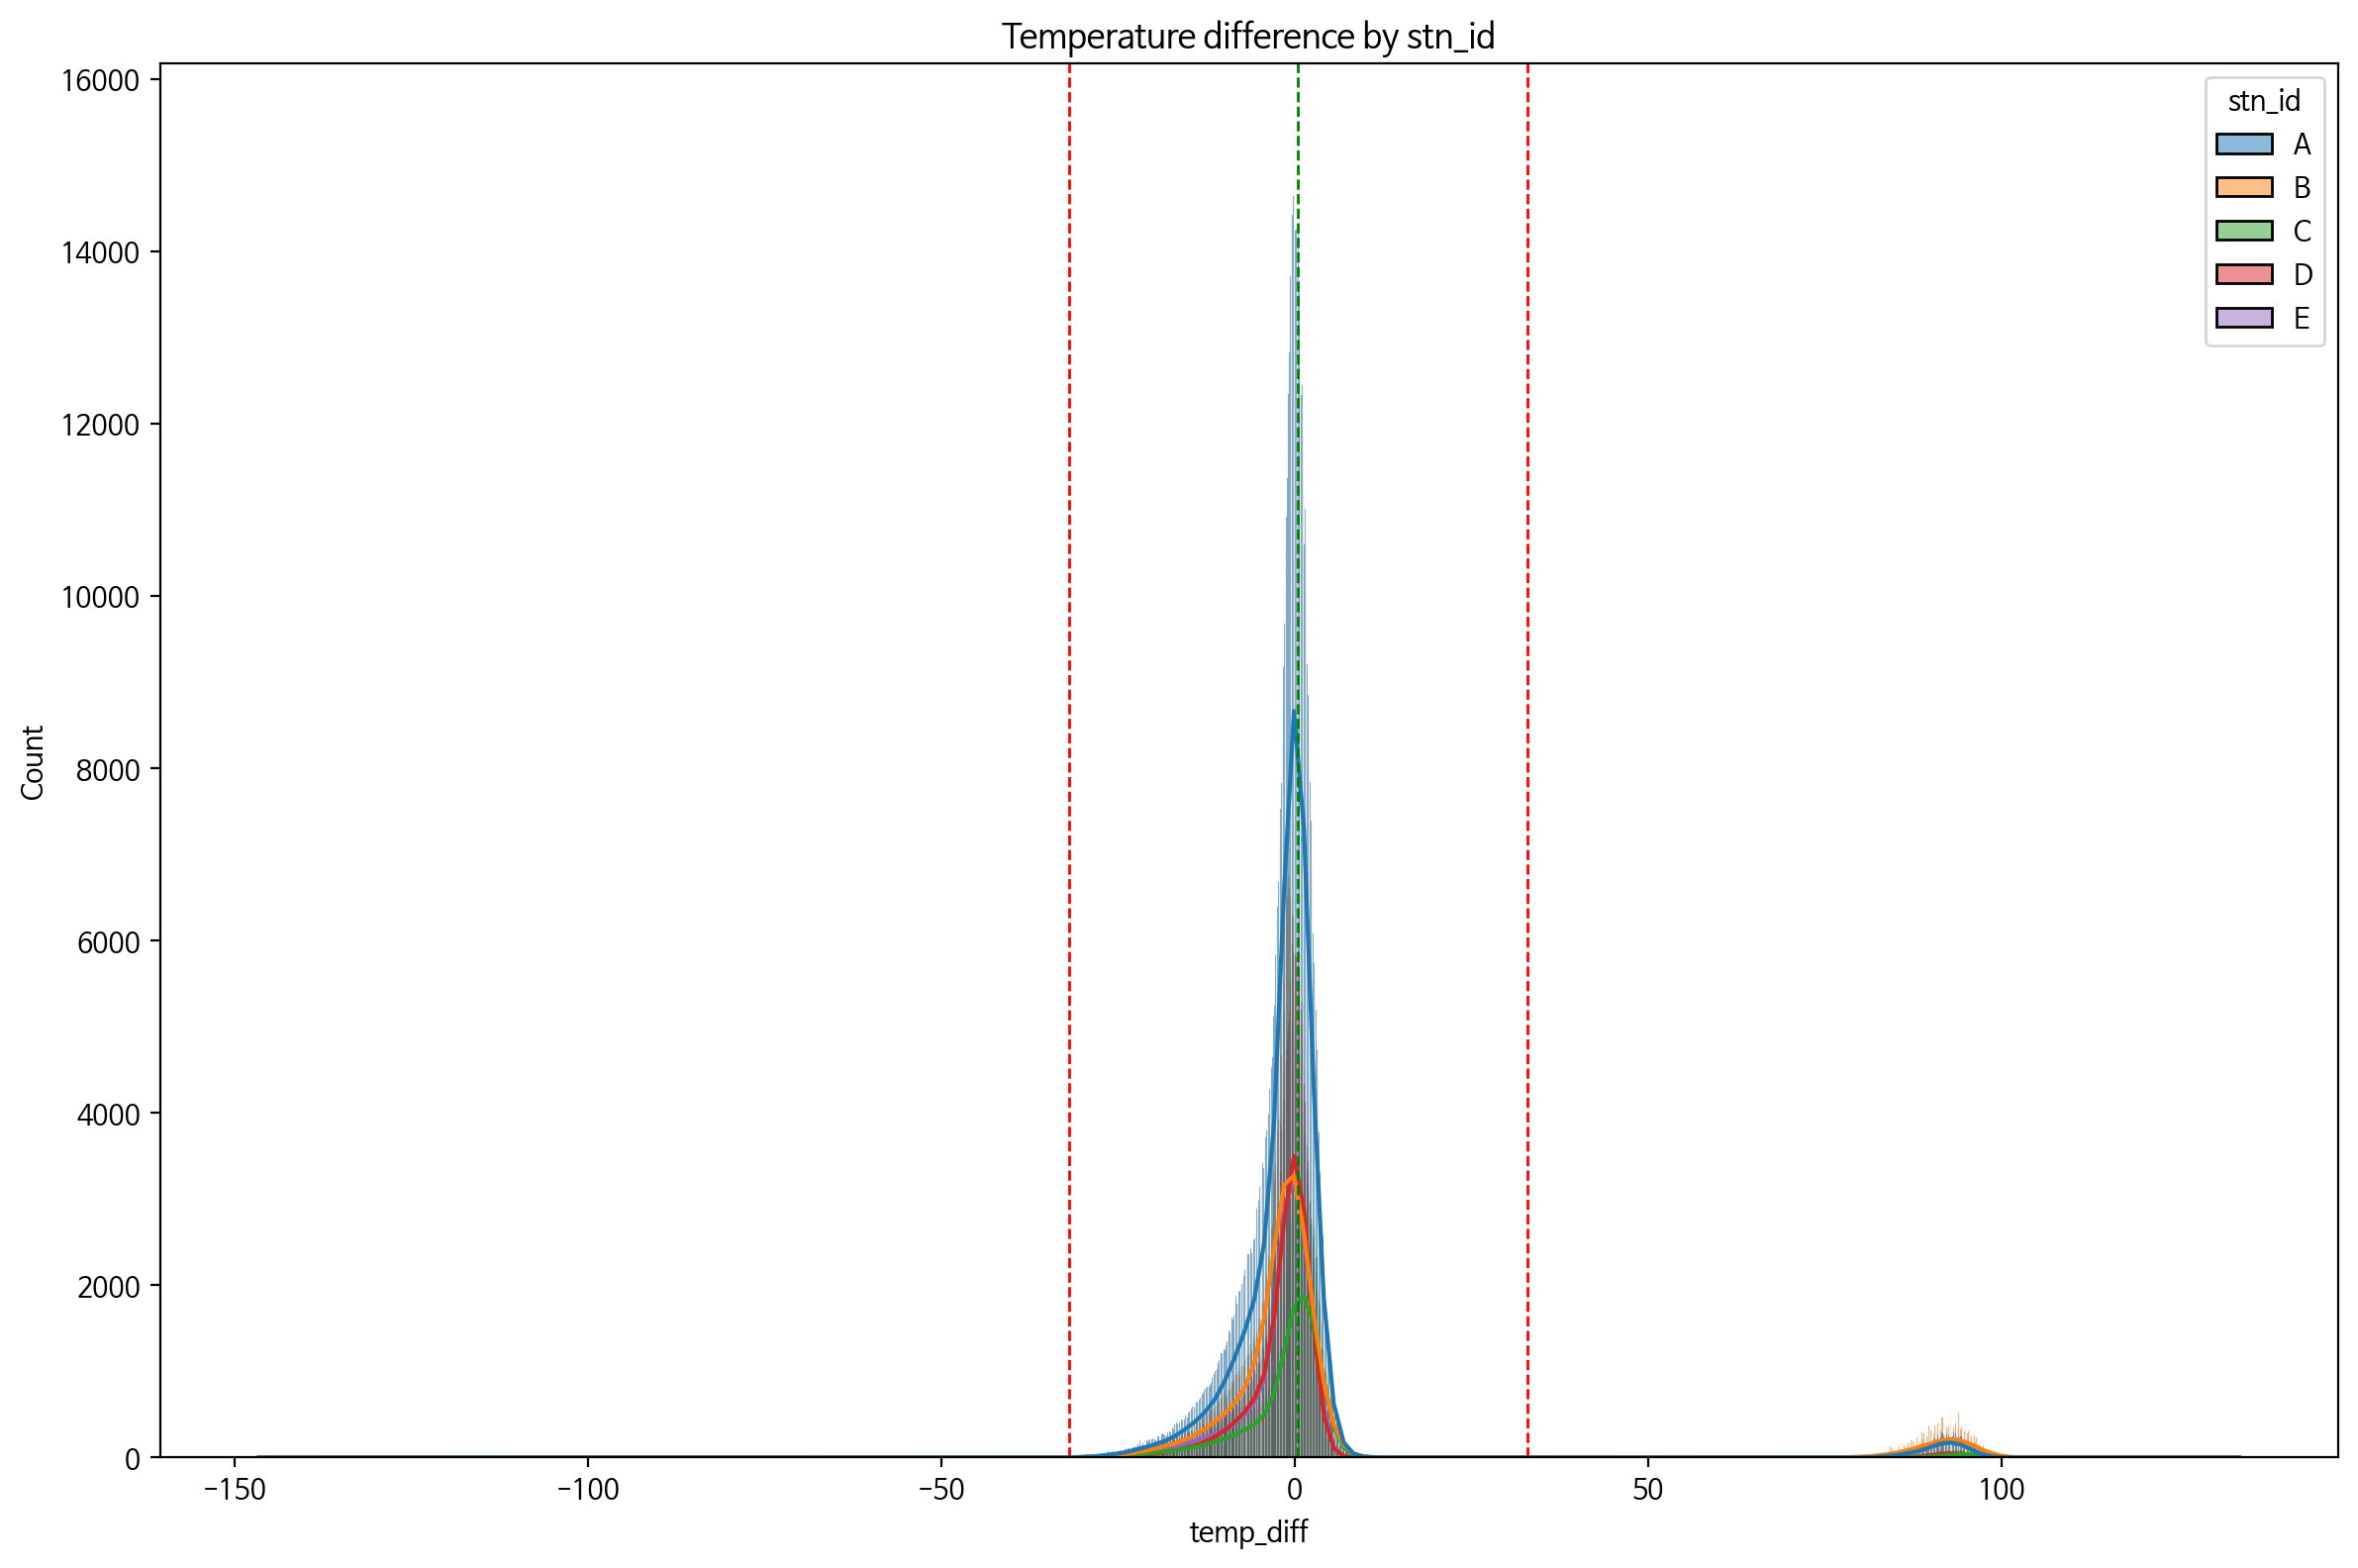

In [54]:
# 표준편차 기준 -2~2 범위 계산
std_minus_2 = np.mean(train_df["temp_diff"]) - 2 * np.std(train_df["temp_diff"])
std_plus_2 = np.mean(train_df["temp_diff"]) + 2 * np.std(train_df["temp_diff"])

plt.figure(figsize=(12, 8))

# 히스토그램 생성
sns.histplot(data=train_df, 
             x="temp_diff", 
             kde=True, 
             hue="stn_id",
             hue_order=["A", "B", "C", "D", "E"])

# 평균선 추가
plt.axvline(np.mean(train_df["temp_diff"]), color='g', linestyle='--', linewidth=1, label='Mean')

# 표준편차 기준 -2~2 범위선 추가
plt.axvline(std_minus_2, color='r', linestyle='--', linewidth=1, label='-2 Std Dev')
plt.axvline(std_plus_2, color='r', linestyle='--', linewidth=1, label='+2 Std Dev')


plt.title("Temperature difference by stn_id")
plt.tight_layout()

plt.show()

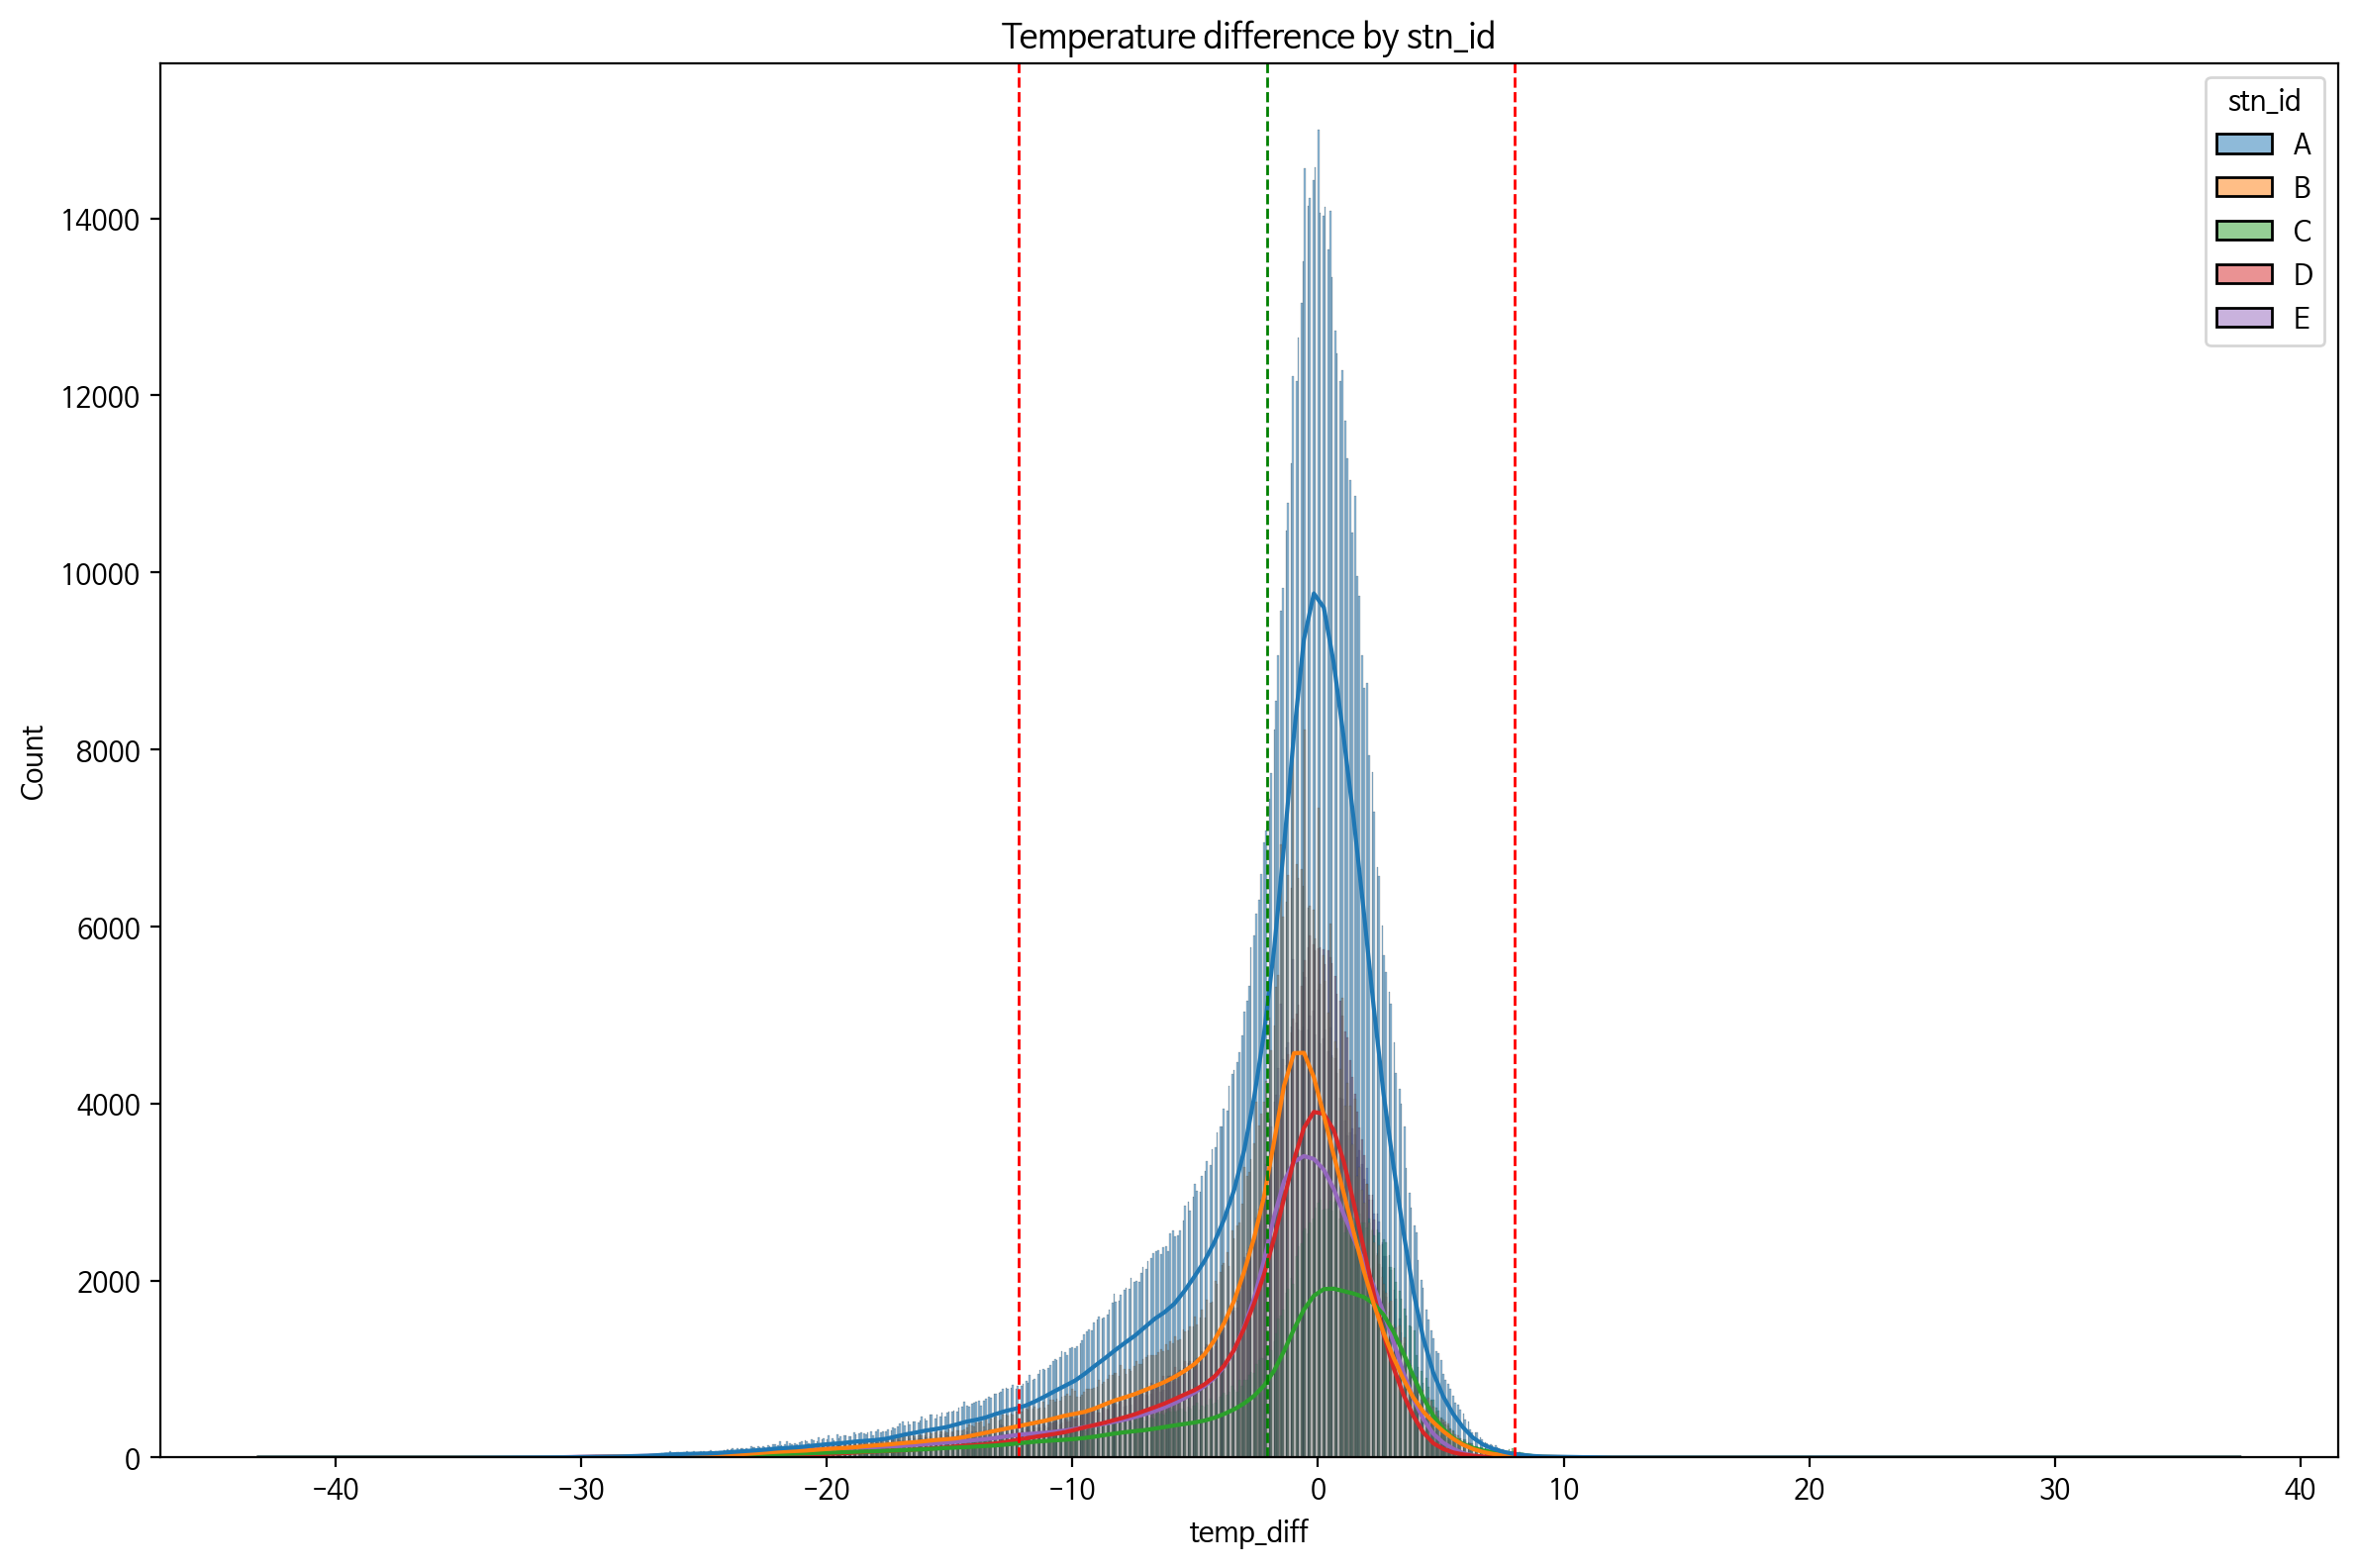

In [55]:
# 결측치 중간에 제거한 train_df_copy로 이상치 확인 

# 표준편차 기준 -2~2 범위 계산
std_minus_2 = np.mean(train_df_copy["temp_diff"]) - 2 * np.std(train_df_copy["temp_diff"])
std_plus_2 = np.mean(train_df_copy["temp_diff"]) + 2 * np.std(train_df_copy["temp_diff"])

plt.figure(figsize=(12, 8))

# 히스토그램 생성
sns.histplot(data=train_df_copy, 
             x="temp_diff", 
             kde=True, 
             hue="stn_id",
             hue_order=["A", "B", "C", "D", "E"])

# 평균선 추가
plt.axvline(np.mean(train_df_copy["temp_diff"]), color='g', linestyle='--', linewidth=1, label='Mean')

# 표준편차 기준 -2~2 범위선 추가
plt.axvline(std_minus_2, color='r', linestyle='--', linewidth=1, label='-2 Std Dev')
plt.axvline(std_plus_2, color='r', linestyle='--', linewidth=1, label='+2 Std Dev')


plt.title("Temperature difference by stn_id")
plt.tight_layout()

plt.show()

In [56]:
# 월별 temp_diff 컬럼 평균
train_df.groupby("month")["temp_diff"].mean()

month
1     12.176844
2      6.328719
3     -0.960398
4     -2.884260
5     -3.754382
6     -3.900998
7     -3.081666
8     -2.445700
9     -2.214431
10    -2.122846
11    -0.165540
12     8.733534
Name: temp_diff, dtype: float64

##### 4-3-1-1. 월별 temp_diff 이상치 시각화

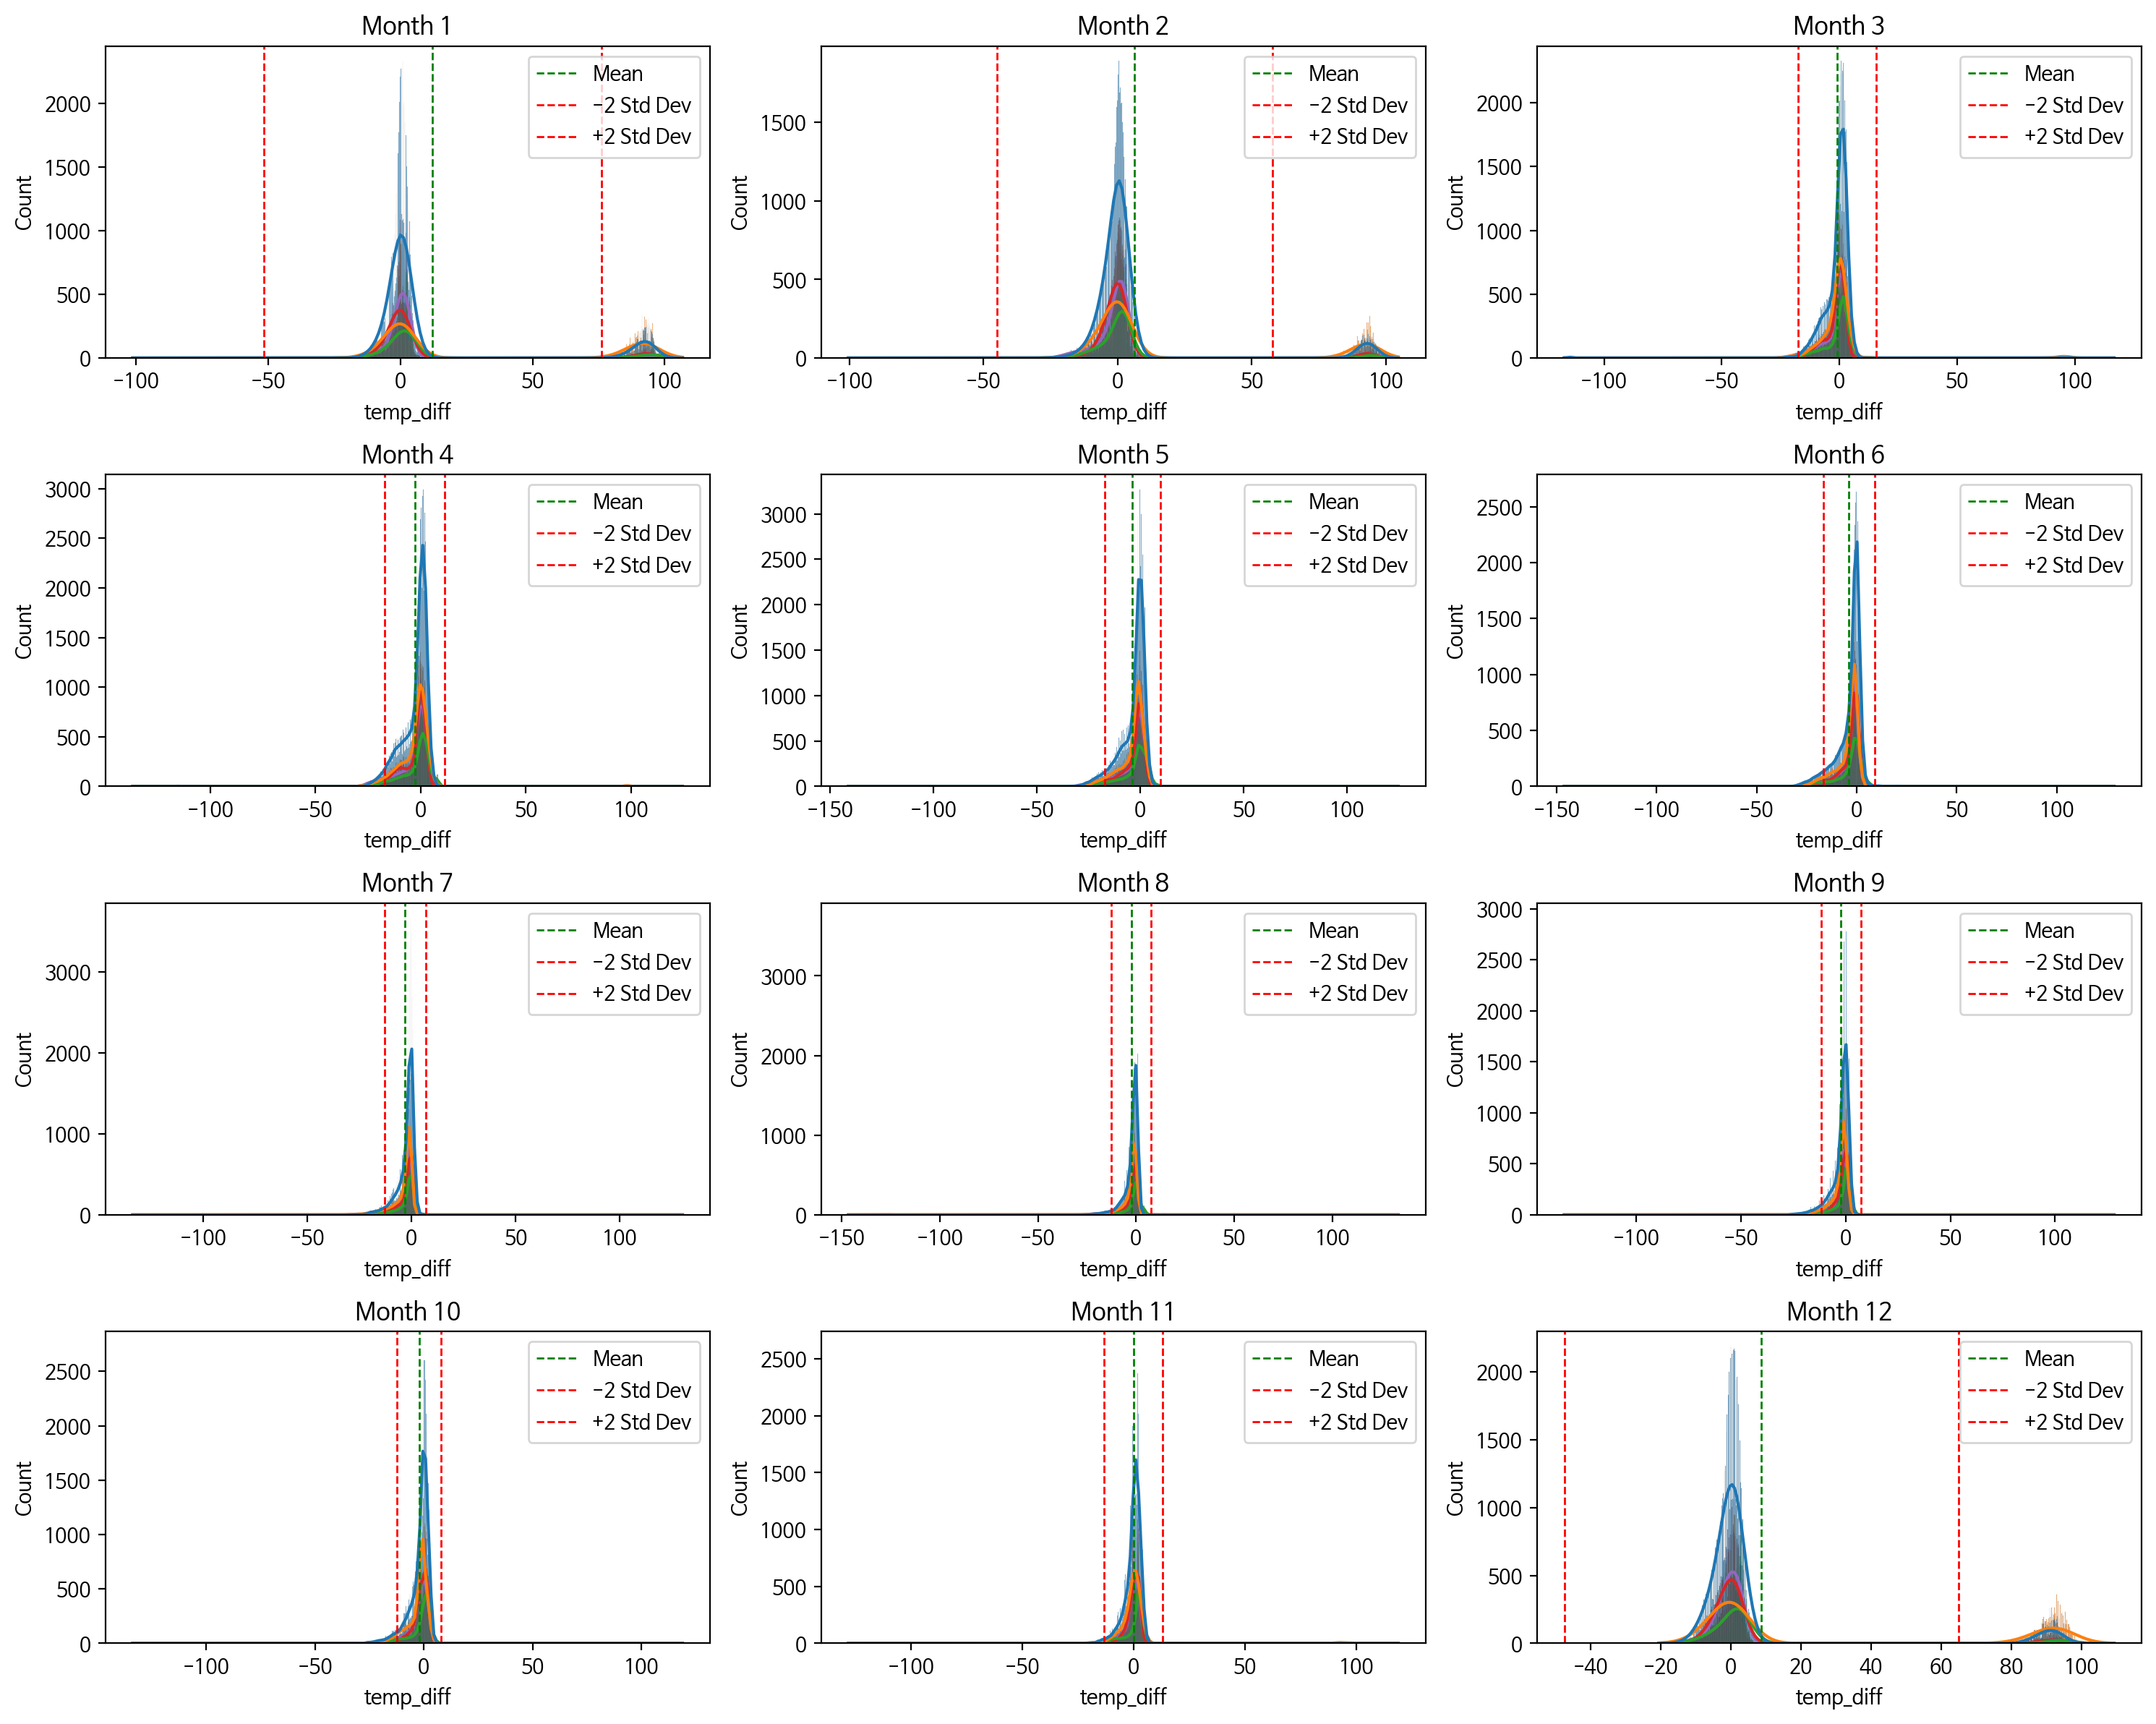

In [56]:
# 서브플롯 생성
fig, axes = plt.subplots(4, 3, figsize=(15, 12))
axes = axes.flatten()

# 12개월에 대해 반복
for month in range(1, 13):
    ax = axes[month - 1]

    month_cond = train_df["month"] == month
    month_mean = np.mean(train_df[month_cond]["temp_diff"])
    std_minus_2 = month_mean - 2 * np.std(train_df[month_cond]["temp_diff"])
    std_plus_2 = month_mean + 2 * np.std(train_df[month_cond]["temp_diff"])

    # 히스토그램 생성
    sns.histplot(data=train_df[month_cond], 
                 x="temp_diff", 
                 kde=True, 
                 hue="stn_id",
                 hue_order=["A", "B", "C", "D", "E"],
                 ax=ax)

    # 평균선 추가
    ax.axvline(month_mean, color='g', linestyle='--', linewidth=1, label='Mean')

    # 표준편차 기준 -2~2 범위선 추가
    ax.axvline(std_minus_2, color='r', linestyle='--', linewidth=1, label='-2 Std Dev')
    ax.axvline(std_plus_2, color='r', linestyle='--', linewidth=1, label='+2 Std Dev')

    ax.set_title(f"Month {month}")
    ax.legend()

plt.tight_layout()
plt.show()

# 겨울 (12, 1, 2)에 temp_diff 큰 숫자들 발견됨
# 결측치가 -99.9로 처리되어서 그런듯
# 결측치가 주로 겨울에 몰려있다.

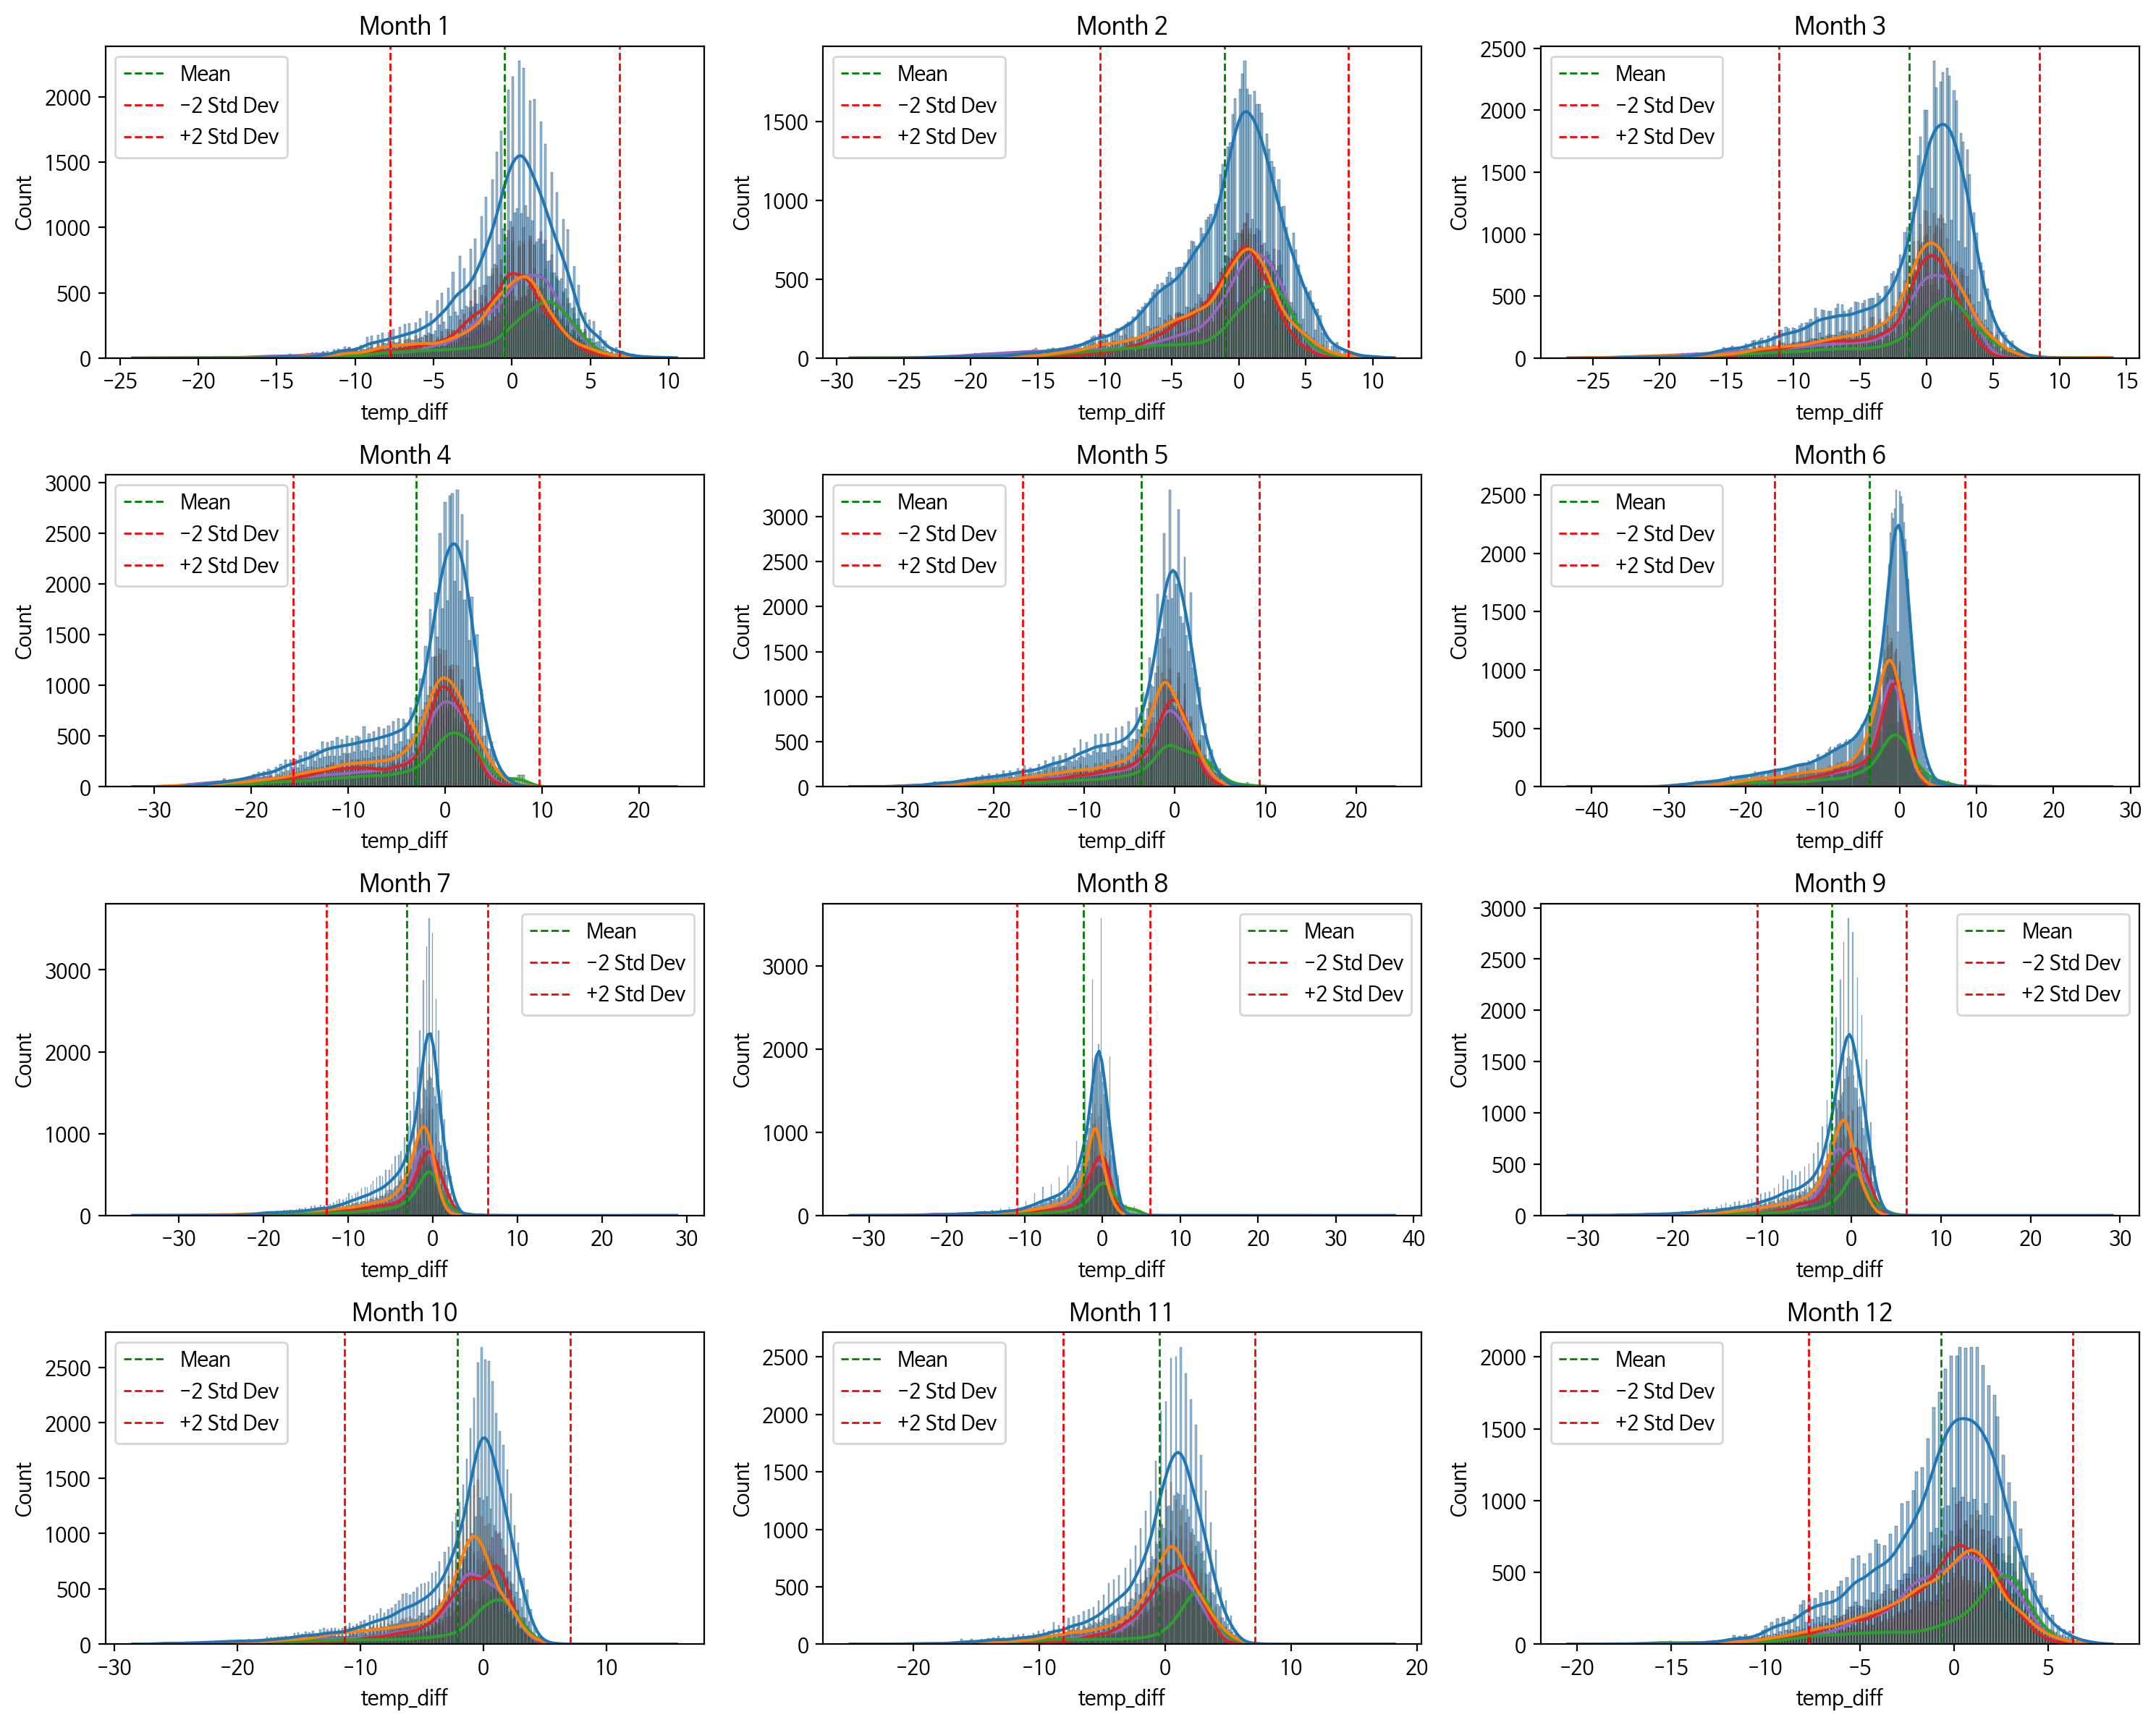

In [57]:
# 결측치 중간에 제거한 train_df_copy로 이상치 확인 

# 서브플롯 생성
fig, axes = plt.subplots(4, 3, figsize=(15, 12))
axes = axes.flatten()

# 12개월에 대해 반복
for month in range(1, 13):
    ax = axes[month - 1]

    month_cond = train_df_copy["month"] == month
    month_mean = np.mean(train_df_copy[month_cond]["temp_diff"])
    std_minus_2 = month_mean - 2 * np.std(train_df_copy[month_cond]["temp_diff"])
    std_plus_2 = month_mean + 2 * np.std(train_df_copy[month_cond]["temp_diff"])

    # 히스토그램 생성
    sns.histplot(data=train_df_copy[month_cond], 
                 x="temp_diff", 
                 kde=True, 
                 hue="stn_id",
                 hue_order=["A", "B", "C", "D", "E"],
                 ax=ax)

    # 평균선 추가
    ax.axvline(month_mean, color='g', linestyle='--', linewidth=1, label='Mean')

    # 표준편차 기준 -2~2 범위선 추가
    ax.axvline(std_minus_2, color='r', linestyle='--', linewidth=1, label='-2 Std Dev')
    ax.axvline(std_plus_2, color='r', linestyle='--', linewidth=1, label='+2 Std Dev')

    ax.set_title(f"Month {month}")
    ax.legend()

plt.tight_layout()
plt.show()

# 겨울 (12, 1, 2)에 temp_diff 큰 숫자들 발견됨
# 결측치가 -99.9로 처리되어서 그런듯
# 결측치가 주로 겨울에 몰려있다.

##### 4-3-1-2. 관측소별 temp_diff 이상치 시각화

In [58]:
# 관측소별 temp_diff 컬럼 평균
train_df.groupby("stn_id")["temp_diff"].mean()

stn_id
A    0.152722
B    3.719196
C    0.159474
D   -0.525526
E   -1.794904
Name: temp_diff, dtype: float64

In [59]:
np.unique(train_df["stn_id"])

array(['A', 'B', 'C', 'D', 'E'], dtype=object)

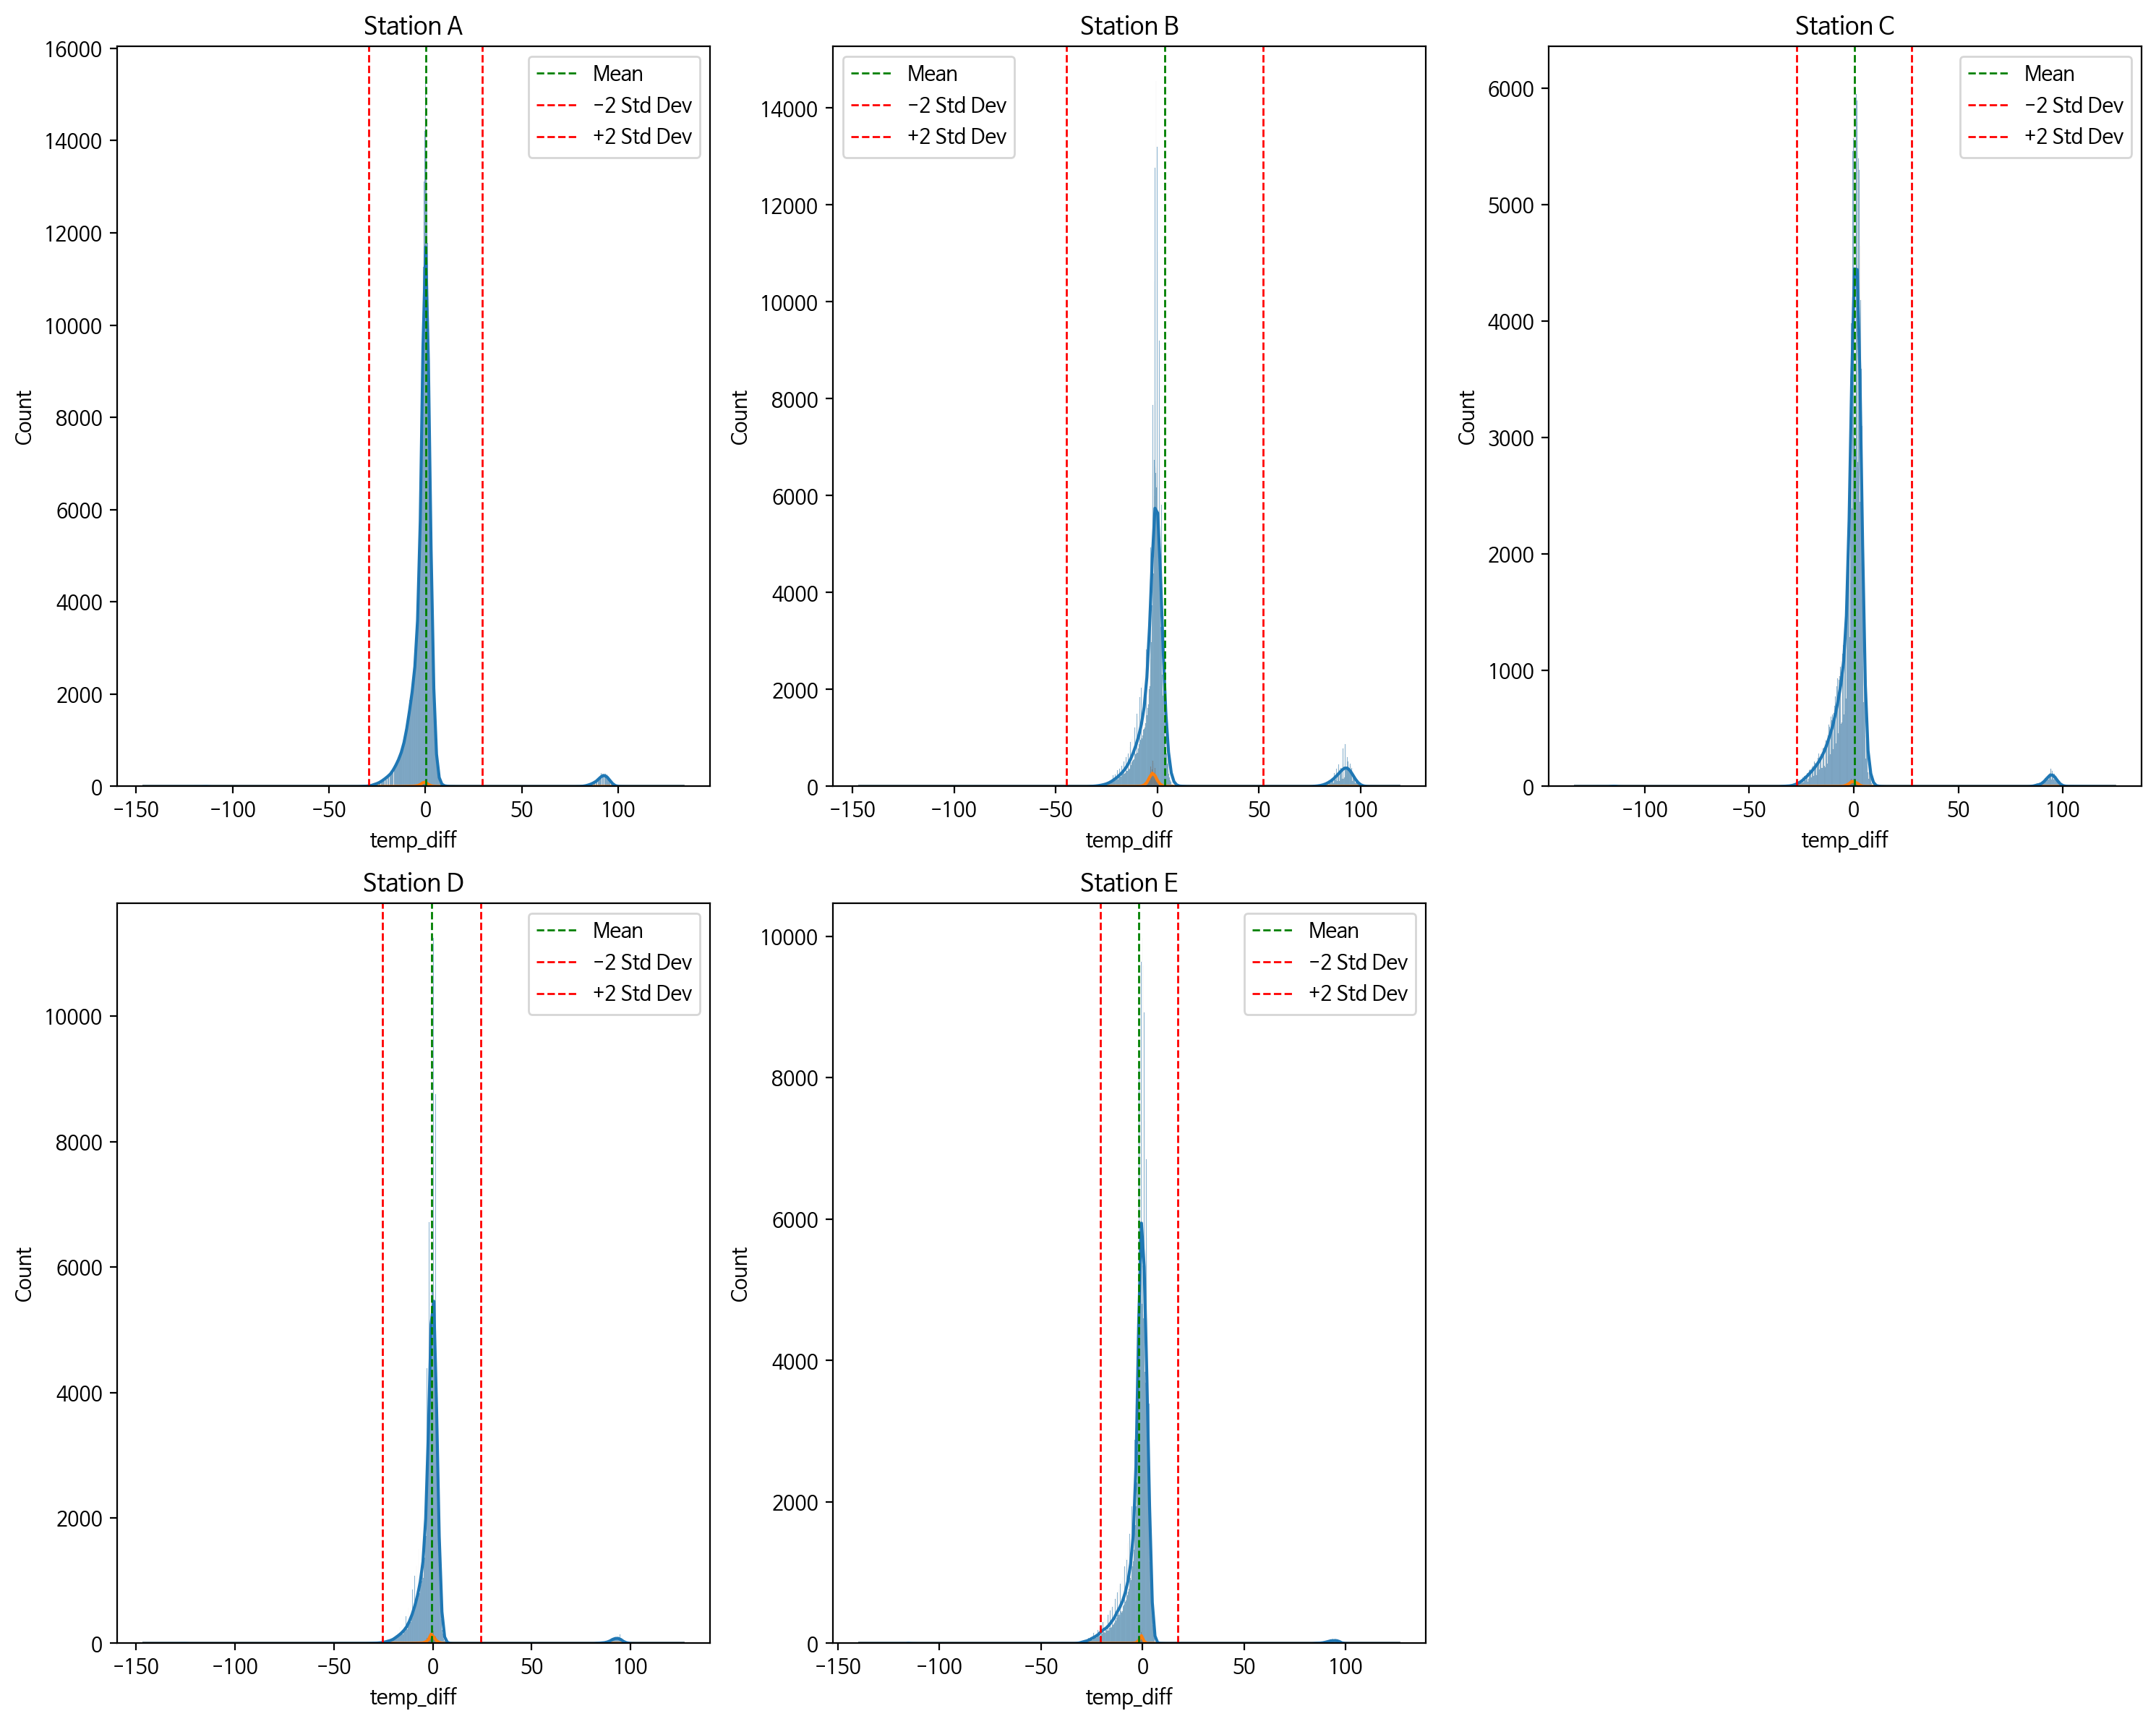

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# 서브플롯 생성
fig, axes = plt.subplots(2, 3, figsize=(15, 12))
axes = axes.flatten()

# stn_id에 대해 반복
for idx, stn_id in enumerate(np.unique(train_df["stn_id"])):
    ax = axes[idx]

    stn_cond = train_df["stn_id"] == stn_id
    stn_mean = np.mean(train_df[stn_cond]["temp_diff"])
    std_minus_2 = stn_mean - 2 * np.std(train_df[stn_cond]["temp_diff"])
    std_plus_2 = stn_mean + 2 * np.std(train_df[stn_cond]["temp_diff"])

    # 히스토그램 생성
    sns.histplot(data=train_df[stn_cond], 
                 x="temp_diff", 
                 kde=True, 
                 hue="is_fog",
                 ax=ax)

    # 평균선 추가
    ax.axvline(stn_mean, color='g', linestyle='--', linewidth=1, label='Mean')

    # 표준편차 기준 -2~2 범위선 추가
    ax.axvline(std_minus_2, color='r', linestyle='--', linewidth=1, label='-2 Std Dev')
    ax.axvline(std_plus_2, color='r', linestyle='--', linewidth=1, label='+2 Std Dev')

    ax.set_title(f"Station {stn_id}")
    ax.legend()

# 빈 subplot 삭제
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])


plt.tight_layout()
plt.show()

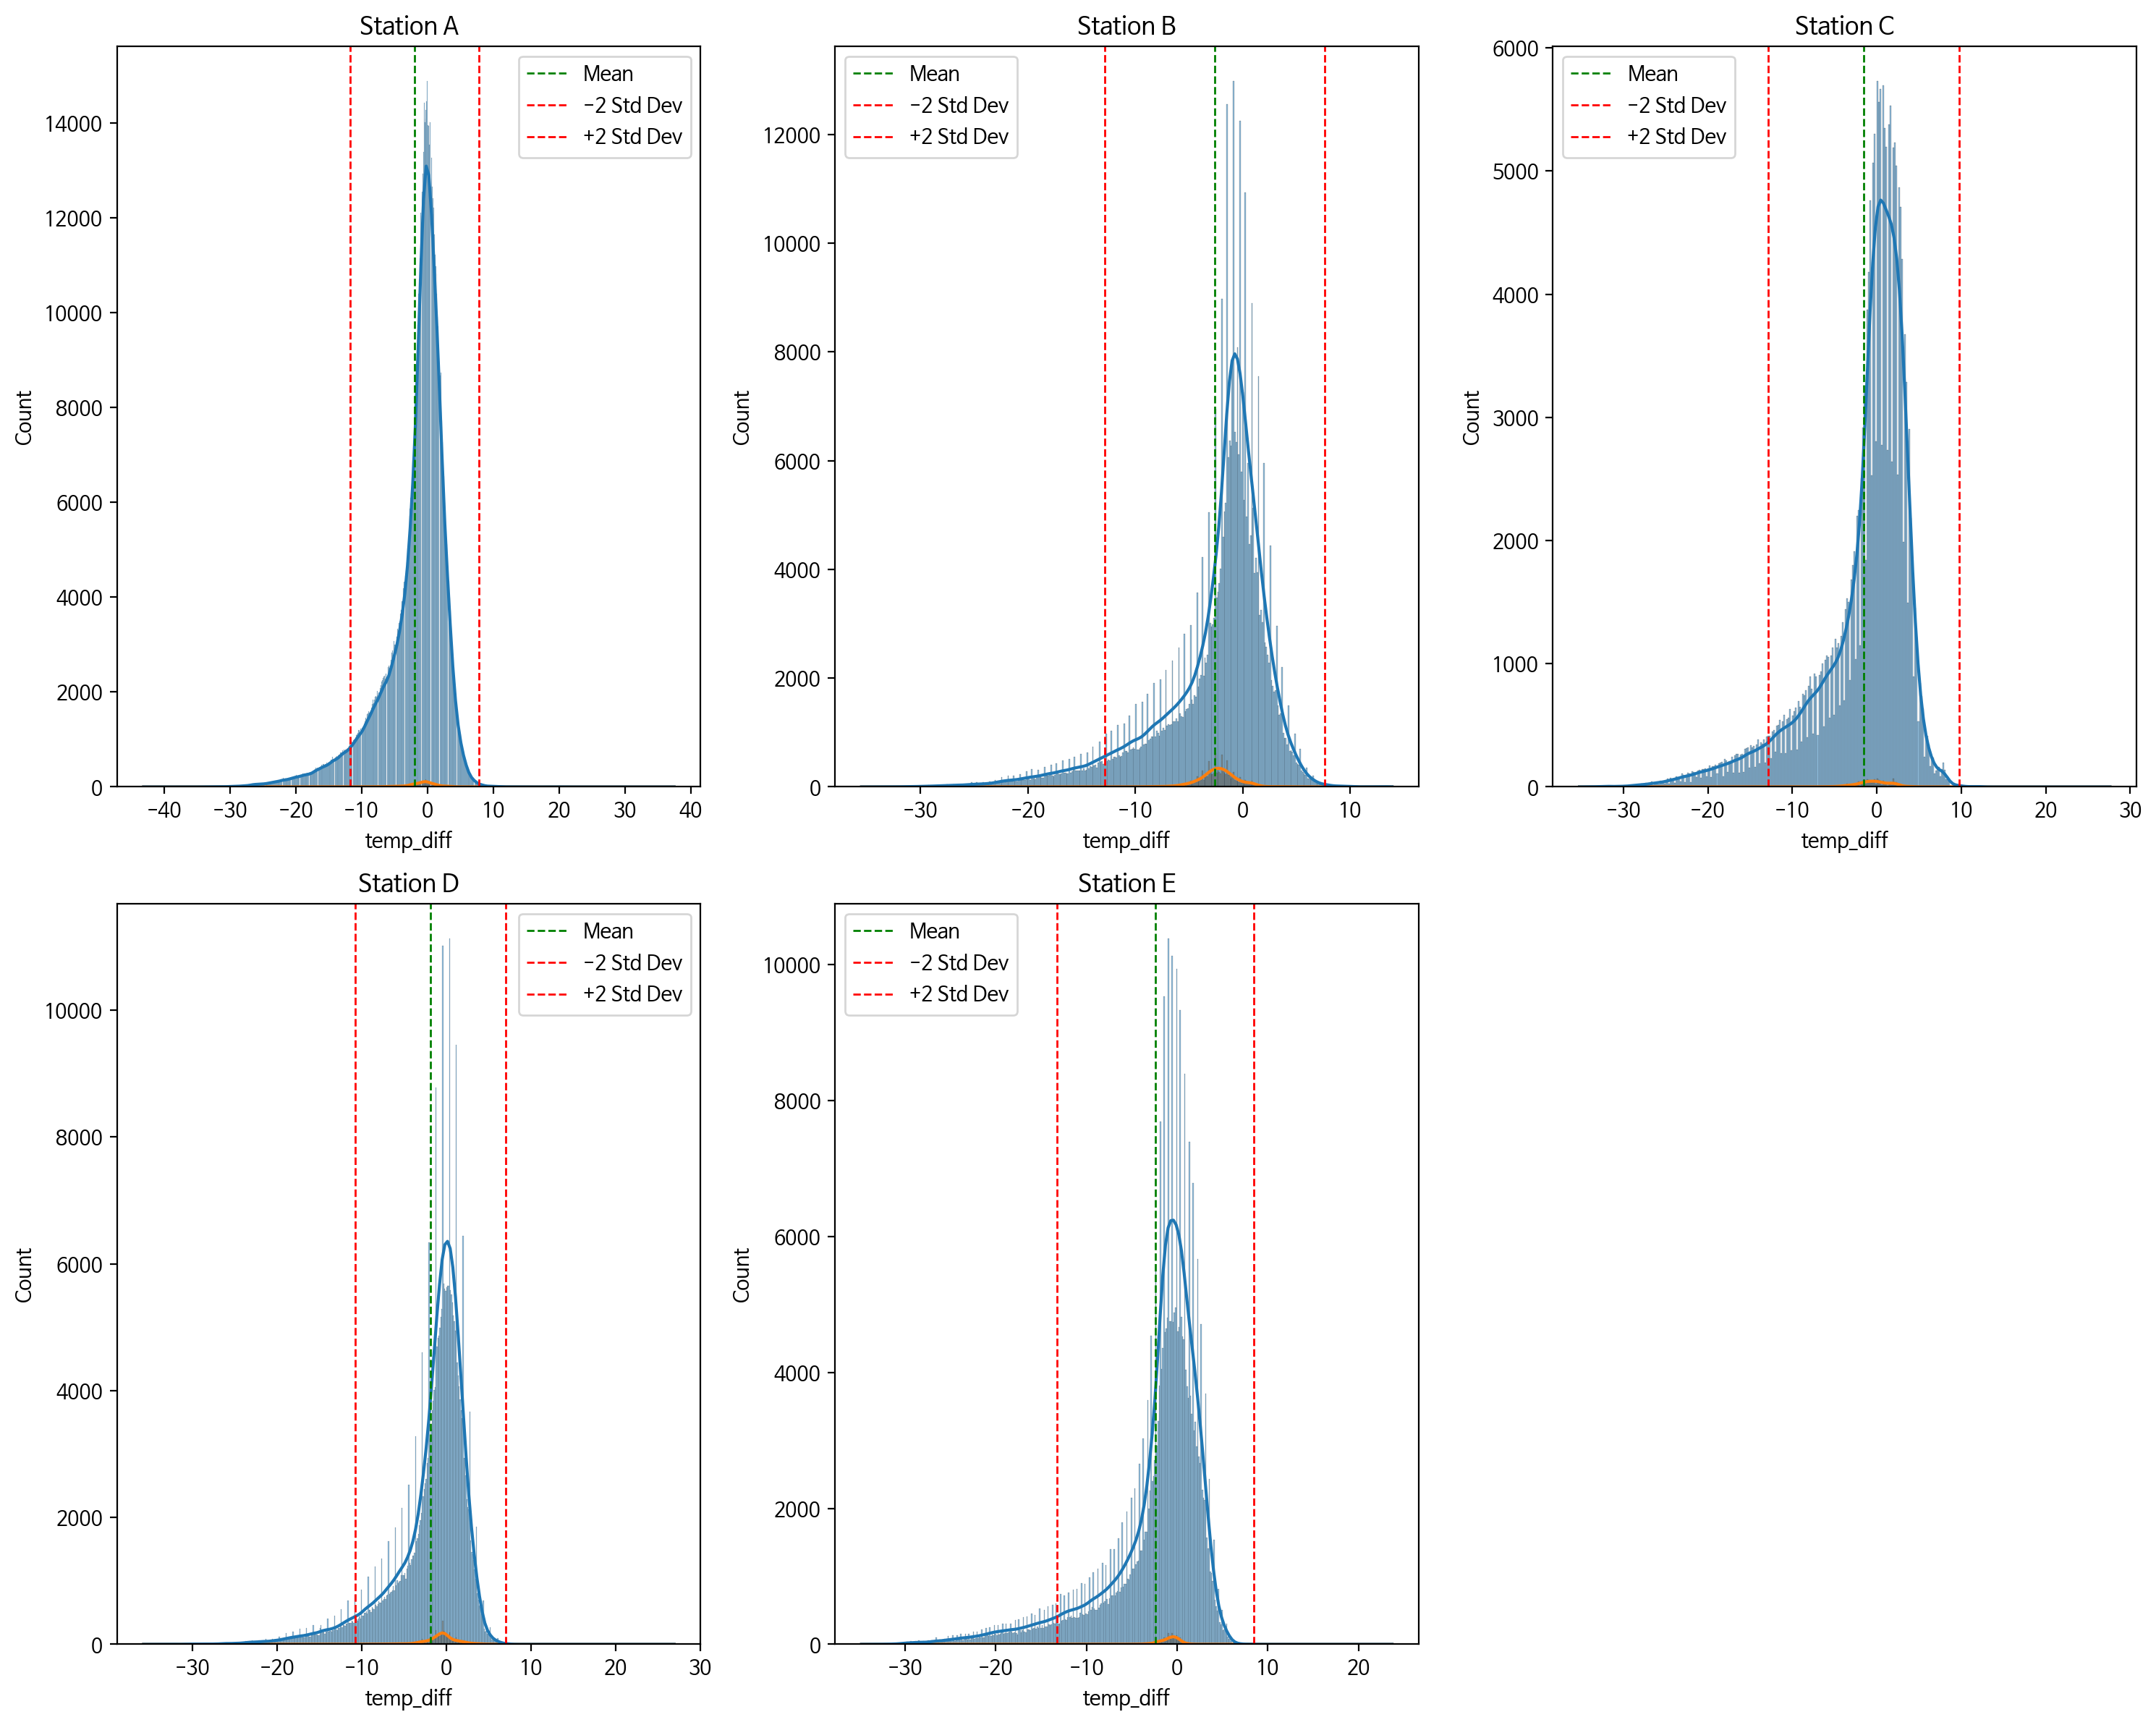

In [61]:
# 결측치 중간에 제거한 train_df_copy로 이상치 확인 

# 서브플롯 생성
fig, axes = plt.subplots(2, 3, figsize=(15, 12))
axes = axes.flatten()

# stn_id에 대해 반복
for idx, stn_id in enumerate(np.unique(train_df_copy["stn_id"])):
    ax = axes[idx]

    stn_cond = train_df_copy["stn_id"] == stn_id
    stn_mean = np.mean(train_df_copy[stn_cond]["temp_diff"])
    std_minus_2 = stn_mean - 2 * np.std(train_df_copy[stn_cond]["temp_diff"])
    std_plus_2 = stn_mean + 2 * np.std(train_df_copy[stn_cond]["temp_diff"])

    # 히스토그램 생성
    sns.histplot(data=train_df_copy[stn_cond], 
                 x="temp_diff", 
                 kde=True, 
                 hue="is_fog",
                 ax=ax)

    # 평균선 추가
    ax.axvline(stn_mean, color='g', linestyle='--', linewidth=1, label='Mean')

    # 표준편차 기준 -2~2 범위선 추가
    ax.axvline(std_minus_2, color='r', linestyle='--', linewidth=1, label='-2 Std Dev')
    ax.axvline(std_plus_2, color='r', linestyle='--', linewidth=1, label='+2 Std Dev')

    ax.set_title(f"Station {stn_id}")
    ax.legend()

# 빈 subplot 삭제
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])


plt.tight_layout()
plt.show()

#### 4-3-2. 이상치 처리
- `temp_diff` 표준편차 기준 -2 ~ 2 범위로 이상치 판단
- `ta`, `ts`, `hm`, `ws10_ms` : 표준편차 기준 -3 ~ 3 범위로 이상치 판단

In [57]:
with open(train_pkl_path,'rb') as f:
    train_df = pickle.load(f)

with open(val_pkl_path,'rb') as f:
    val_df = pickle.load(f)

with open(test_pkl_path,'rb') as f:
    test_df = pickle.load(f)

In [46]:
# 상대습도 0인 데이터 치환
train_df['hm'] = train_df['hm'].replace(0, np.nan)
train_df_copy['hm'] = train_df_copy['hm'].replace(0, np.nan)

In [63]:
def replace_outliers_with_nan(dataframe, columns, threshold=2):
    dataframe_copy = dataframe.copy()
    
    for column in columns:
        for month in range(1, 13):
            month_cond = dataframe_copy["month"] == month
            data = dataframe_copy.loc[month_cond, column]
            
            if data.empty:
                continue
            
            z_scores = np.abs((data - np.mean(data)) / np.std(data))
            
            # 이상치를 np.nan으로 대체
            dataframe_copy.loc[month_cond & (z_scores > threshold), column] = np.nan
    
    return dataframe_copy

In [ ]:
def replace_outliers_with_nan(dataframe, columns, threshold=2):
    dataframe_copy = dataframe.copy()
    
    for column in columns:
        for month in range(1, 13):
            month_cond = dataframe_copy["month"] == month
            data = dataframe_copy.loc[month_cond, column]
            
            if data.empty:
                continue
            
            z_scores = np.abs((data - np.mean(data)) / np.std(data))
            
            # 이상치를 np.nan으로 대체
            dataframe_copy.loc[month_cond & (z_scores > threshold), column] = np.nan
    
    return dataframe_copy

In [47]:
def replace_outliers_with_nan_stn_id(dataframe, columns, threshold=2):
    dataframe_copy = dataframe.copy()
    
    unique_stn_ids = np.unique(dataframe_copy["stn_id"])
    
    for column in columns:
        for stn_id in unique_stn_ids:
            stn_id_cond = dataframe_copy["stn_id"] == stn_id
            data = dataframe_copy.loc[stn_id_cond, column]
            
            if data.empty:
                continue
            
            z_scores = np.abs((data - np.mean(data)) / np.std(data))
            
            # 이상치를 np.nan으로 대체
            dataframe_copy.loc[stn_id_cond & (z_scores > threshold), column] = np.nan
    
    return dataframe_copy

In [64]:
# 월별 이상치 (표준편차 -2 ~ +2 기준) 확인 후 NaN으로 변경
# train_no_outlier_df = replace_outliers_with_nan(train_df, ["temp_diff"])
# train_no_nan_outlier_df = replace_outliers_with_nan(train_df_copy, ["temp_diff"])

In [65]:
# 월별 이상치 (표준편차 -3 ~ +3 기준) 확인 후 NaN으로 변경
# train_no_outlier_df = replace_outliers_with_nan(train_df, ["ta", "ts", "hm", "ws10_ms"], 3)
# train_no_nan_outlier_df = replace_outliers_with_nan(train_df_copy, ["ta", "ts", "hm", "ws10_ms"], 3)

In [48]:
# 월별 이상치 (표준편차 -2 ~ +2 기준) 확인 후 NaN으로 변경
train_no_outlier_df = replace_outliers_with_nan_stn_id(train_df, ["temp_diff"])
train_no_nan_outlier_df = replace_outliers_with_nan_stn_id(train_df_copy, ["temp_diff"])

In [49]:
# 월별 이상치 (표준편차 -3 ~ +3 기준) 확인 후 NaN으로 변경
train_no_outlier_df = replace_outliers_with_nan_stn_id(train_df, ["ta", "ts", "hm", "ws10_ms"], 3)
train_no_nan_outlier_df = replace_outliers_with_nan_stn_id(train_df_copy, ["ta", "ts", "hm", "ws10_ms"], 3)

#### 4-3-3. 이상치, 결측치 제거

In [50]:
def drop_nan(df):
    df['hm'] = df['hm'].replace(0, np.nan)
    df = df.replace({-99:np.nan, -99.9:np.nan})    
    # train_df = train_df.replace({-99:np.nan, -99.9:np.nan})
    # test_df = test_df.replace({-99:np.nan, -99.9:np.nan})
    df.dropna(inplace=True)
    
    return df

In [51]:
train_no_outlier_df = drop_nan(train_no_outlier_df)
train_no_nan_outlier_df = drop_nan(train_no_nan_outlier_df)

In [52]:
train_no_outlier_df["class"].value_counts()

class
4.0    2221803
2.0       8977
3.0       8956
1.0       5852
Name: count, dtype: int64

In [53]:
train_no_nan_outlier_df["class"].value_counts()

class
4.0    2187331
2.0       8928
3.0       8861
1.0       5836
Name: count, dtype: int64

In [54]:
print("이상치 처리 전 Train 데이터셋 shape:", train_df.shape)

이상치 처리 전 Train 데이터셋 shape: (2350456, 18)


In [55]:
print("Train 데이터 Outlier 제거 :",  train_df.shape[0] - train_no_outlier_df.shape[0], "개")

Train 데이터 Outlier 제거 : 104868 개


In [56]:
print("Train 데이터 Outlier 제거 :",  train_df.shape[0] - train_no_nan_outlier_df.shape[0], "개")

Train 데이터 Outlier 제거 : 139500 개


In [57]:
print("이상치 처리 후 Train 데이터셋 shape:", train_no_outlier_df.shape)

이상치 처리 후 Train 데이터셋 shape: (2245588, 18)


In [58]:
print("이상치 처리 후 Train 데이터셋 shape:", train_no_nan_outlier_df.shape)

이상치 처리 후 Train 데이터셋 shape: (2210956, 18)


### 4-4. 컬럼별 시각화

#### 4-4-1. 수치형 변수

In [59]:
# 수치형 변수 중, vis1 컬럼은 제거 예정
num_cols = train_no_outlier_df.drop(columns="vis1").select_dtypes(include=np.number).columns

print(num_cols)
print(len(num_cols),"개")

Index(['time', 'ws10_deg', 'ws10_ms', 'ta', 're', 'hm', 'sun10', 'ts',
       'dew_point', 'temp_diff'],
      dtype='object')
10 개


In [69]:
def kde_factor_class(dataset, columns_list, class_column = 'class'):

    colors = {
        1: '#FF0000',
        2: '#00FF00',
        3: '#0000FF',
        4: '#777777'
    }

    # about_columns = dataset.columns[0:-2]
    num_columns = len(columns_list)

    # Determine the number of rows and columns for the subplots
    num_rows = (num_columns + 1) // 2

    fig, axes = plt.subplots(num_rows, 2, figsize=(15, num_rows * 5))

    for idx, column in enumerate(columns_list):
        row = idx // 2
        col = idx % 2
        ax = axes[row, col]

        for i in range(1, 5):
            temp_df = dataset[dataset[class_column] == i]
            sns.kdeplot(temp_df[column], label=i, fill=True, color=colors[i], ax=ax)

        ax.set_title("class별 " + column + "KDE plot")
        ax.set_xlabel(column)
        ax.set_ylabel("density")
        ax.legend()

    # Remove any empty subplots
    for j in range(idx + 1, num_rows * 2):
        fig.delaxes(axes.flatten()[j])

    fig.suptitle("KDE Distribution of Numerical Columns by class", fontsize=16)

    # Adjust layout to make room for the figure title
    plt.subplots_adjust(top=0.92, hspace=0.4)

    plt.tight_layout(rect=[0, 0, 1, 0.96])

    plt.show()

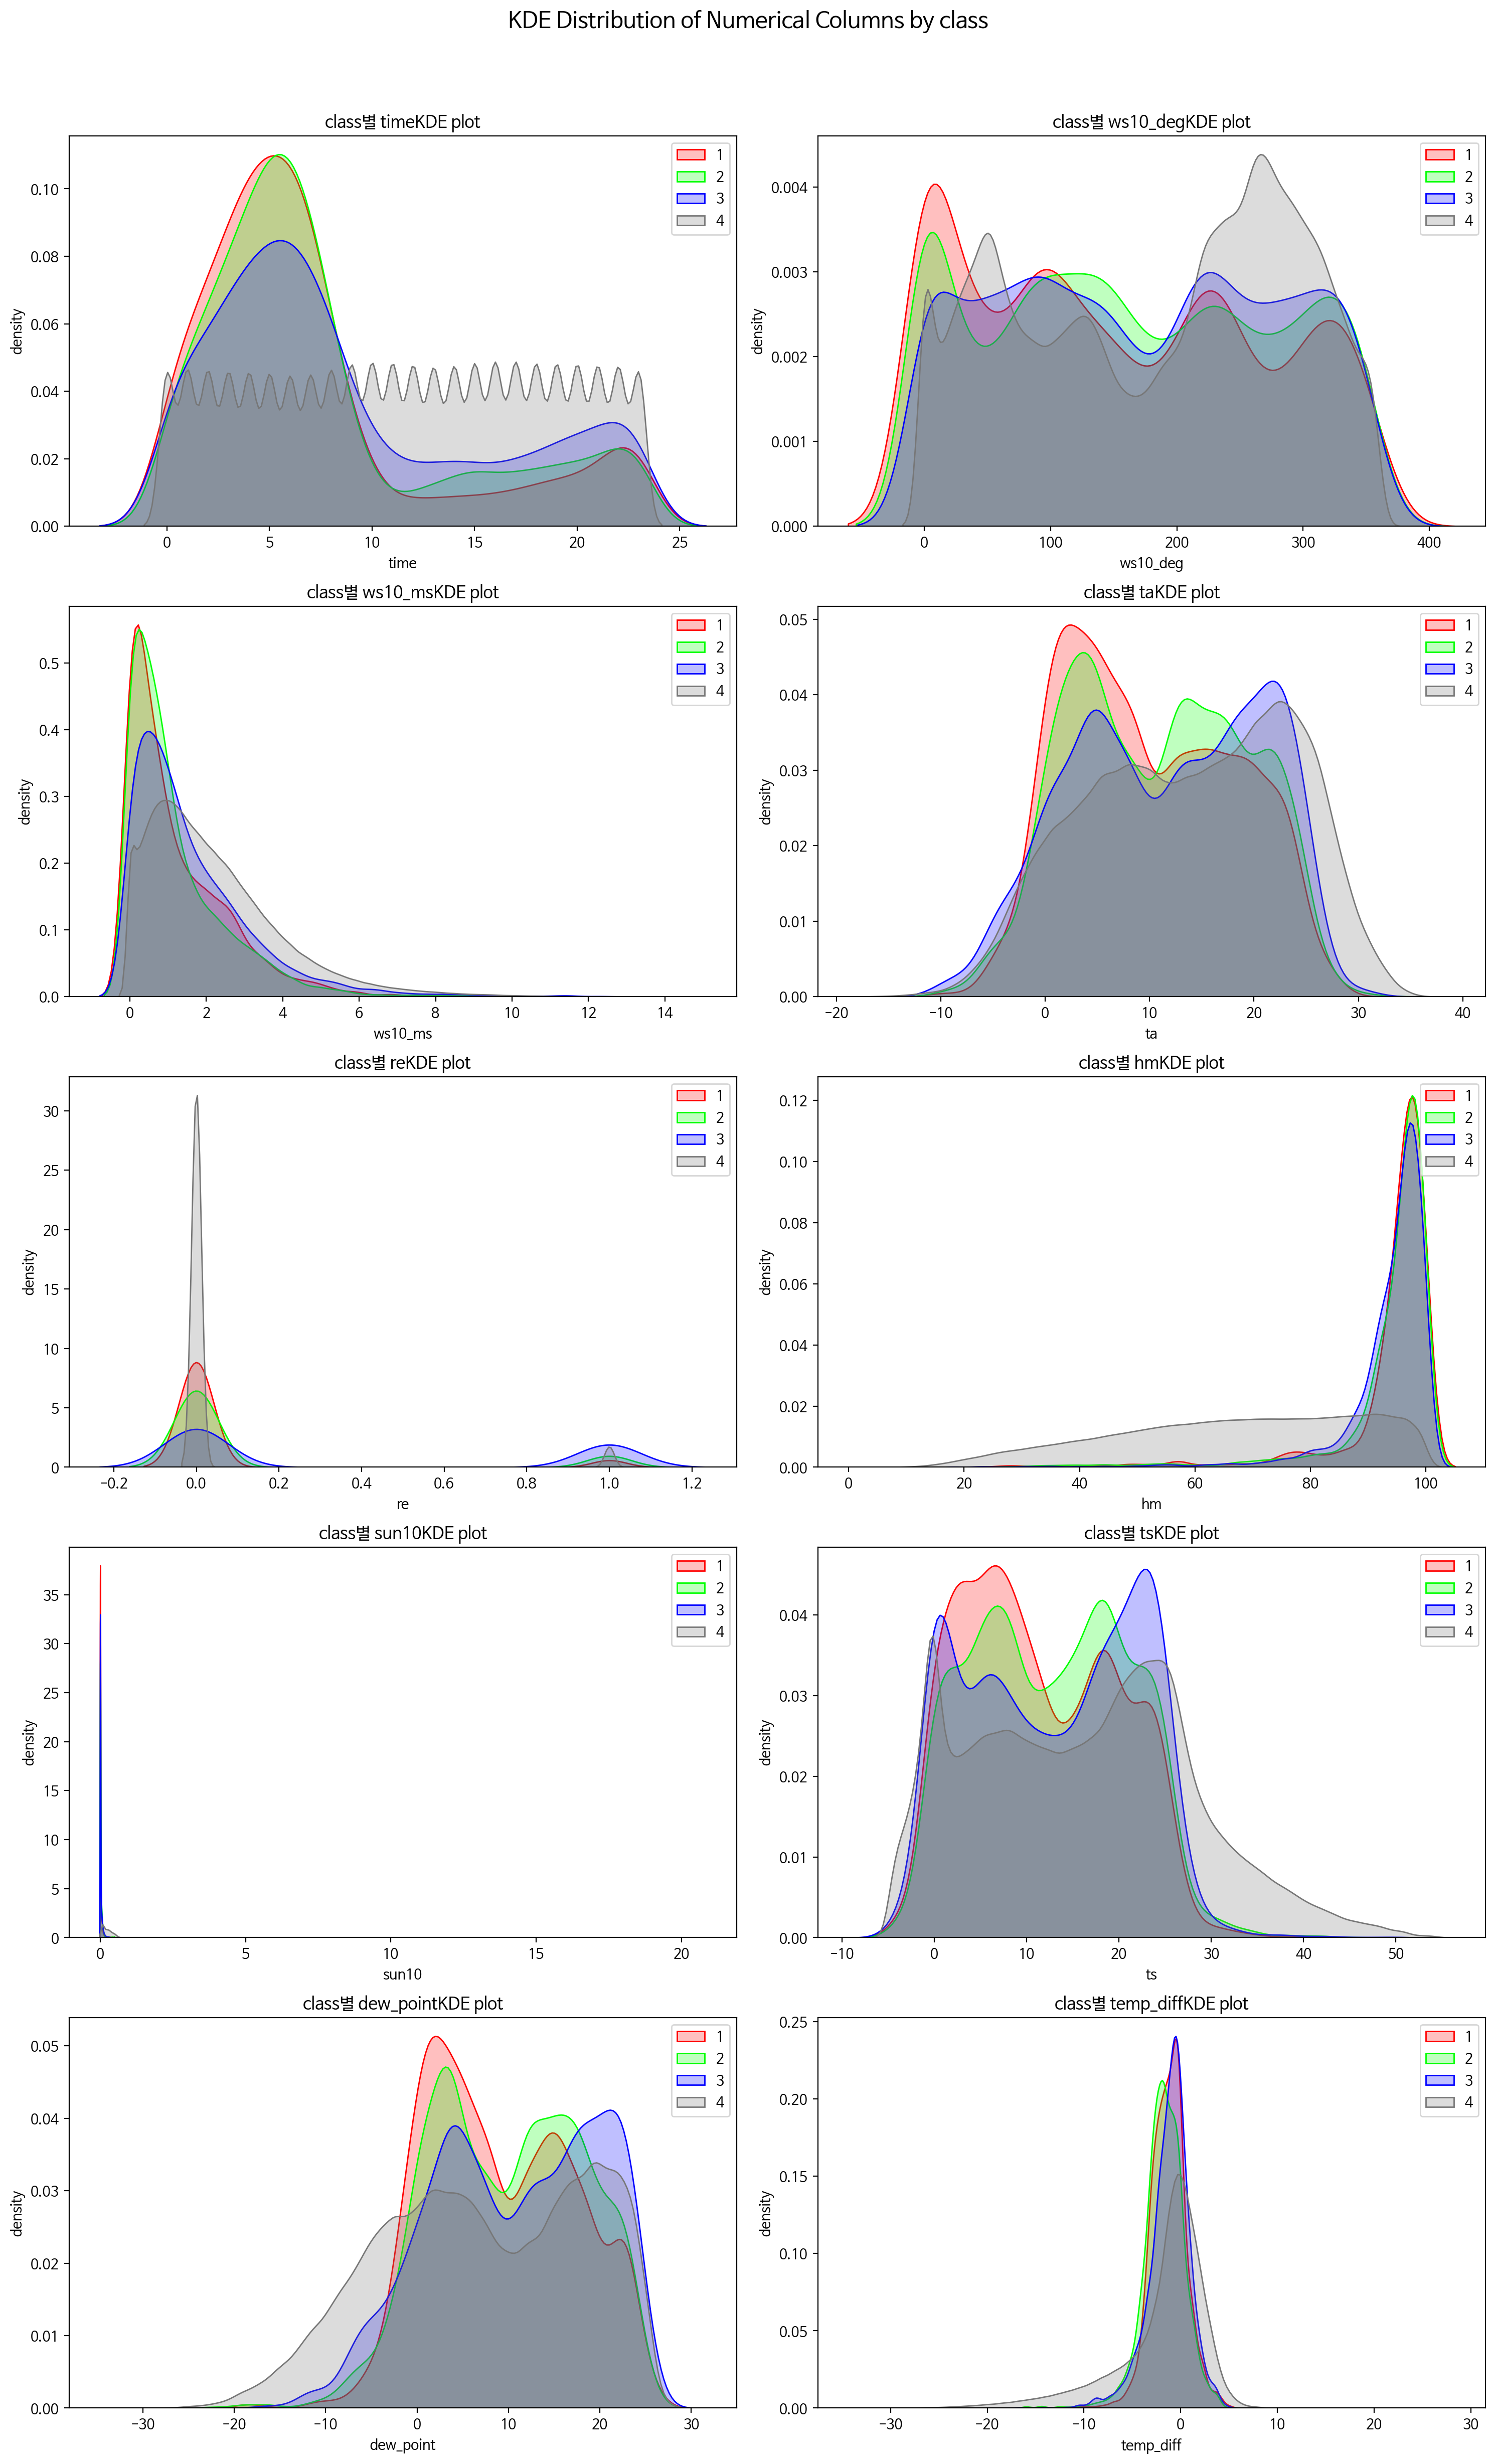

In [70]:
kde_factor_class(train_no_outlier_df, num_cols)

#### 4-4-2. 명목형 변수

In [71]:
str_cols = train_no_outlier_df.select_dtypes(exclude=np.number).columns
str_cols

Index(['year', 'month', 'stn_id', 'class', 'is_fog', 'dew_reached',
       'ws10_dir'],
      dtype='object')

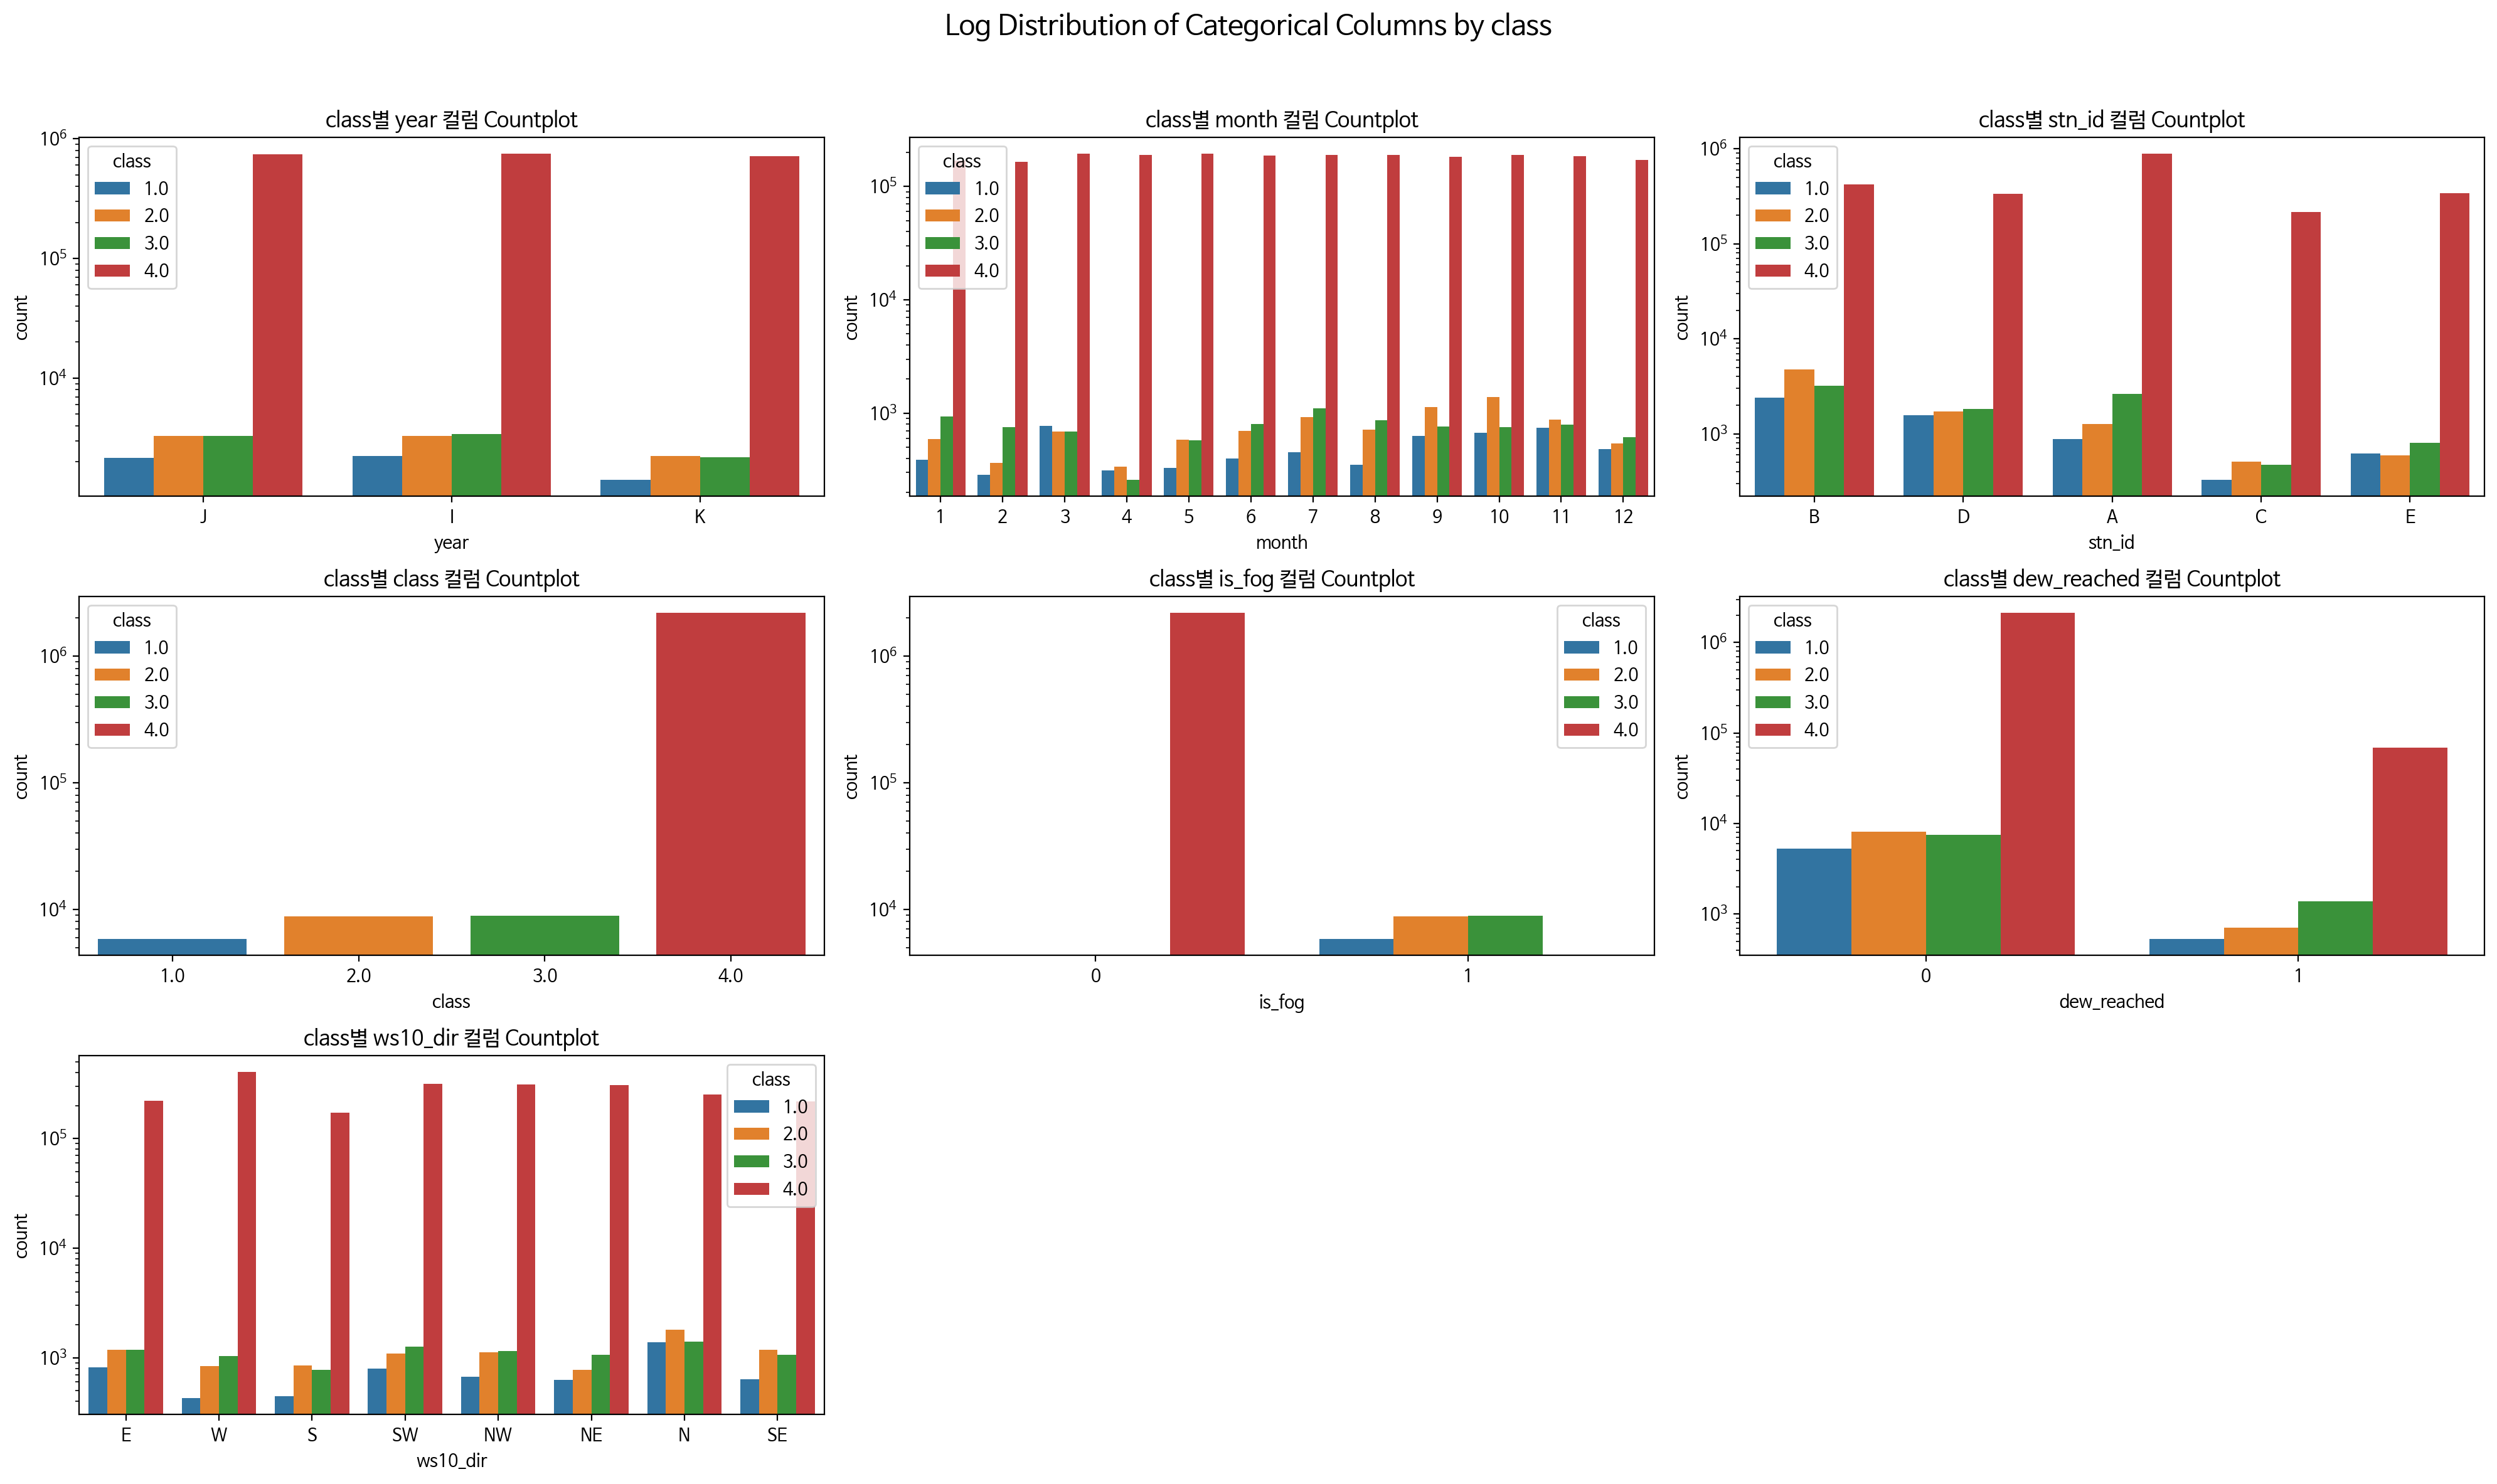

In [72]:
# subplot 생성
nrows, ncols = 3, 3
fig, axes = plt.subplots(nrows, ncols, figsize=(20, 12))

# flatten()을 통해 axes를 1차원 array로 변환
axes = axes.flatten()

for col, ax in zip(str_cols, axes):
    sns.countplot(data=train_no_outlier_df, x=col, ax=ax, hue="class")
    # if col == "class":
    #     sns.countplot(data=train_no_outlier_df, x=col, ax=ax, hue="class")
    # else:
    #     sns.countplot(data=train_no_outlier_df, x=col, ax=ax, hue="class")
    
    # y축을 로그 스케일로 설정
    ax.set_yscale('log')
    # ax.get_yaxis().get_major_formatter().set_scientific(False)
    ax.set_title("class별 " + col + " 컬럼 Countplot")

# 빈 subplot 제거
if len(str_cols) < len(axes):
    for i in range(len(str_cols), len(axes)):
        fig.delaxes(axes[i])

fig.suptitle("Log Distribution of Categorical Columns by class", fontsize=16)

# Adjust layout to make room for the figure title
plt.subplots_adjust(top=0.92, hspace=0.4)
plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.show()


### 4-5. 상관관계 확인

In [73]:
num_cols = train_no_outlier_df.describe().columns
train_df_corr = train_no_outlier_df[num_cols].corr()

train_df_corr.style.background_gradient()

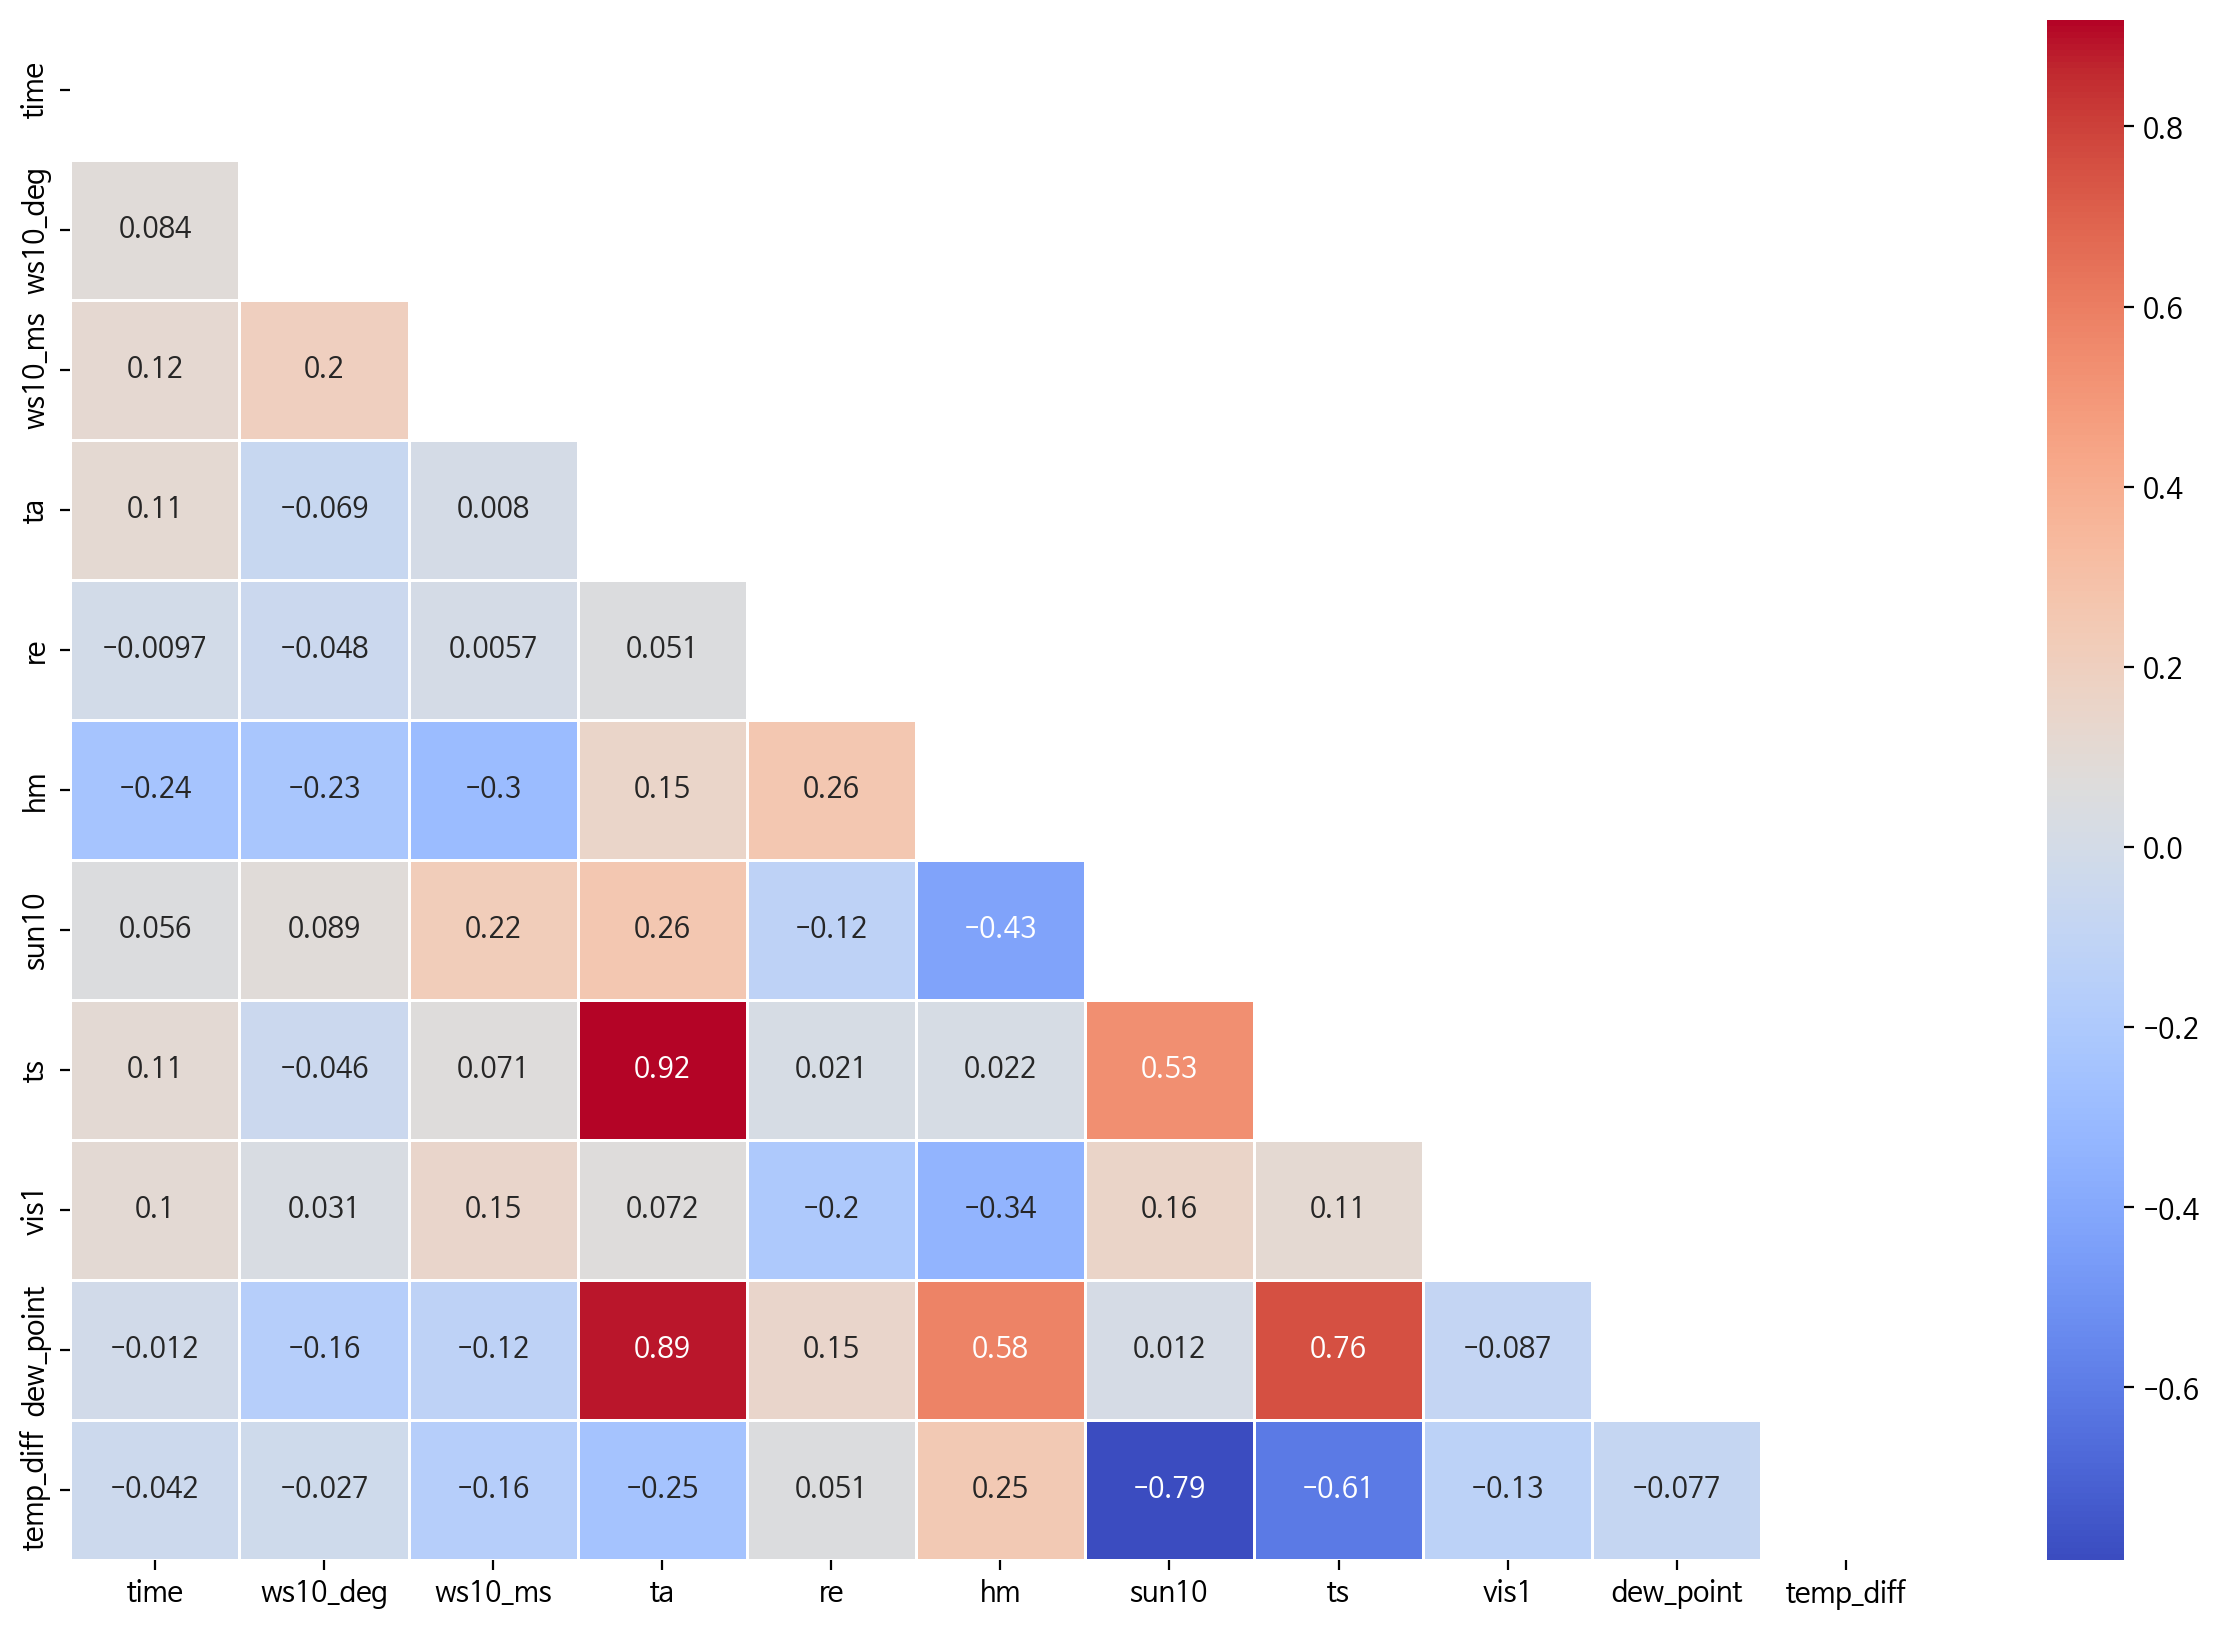

In [74]:
plt.figure(figsize=(15,10))

# 삼각형 마스크를 만든다(위 쪽 삼각형에 True, 아래 삼각형에 False)
mask = np.zeros_like(train_df_corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(train_df_corr,
            annot=True,         # 실제 값을 표시한다
            mask=mask,          # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,      # 경계면 실선으로 구분하기
            cmap='coolwarm')
plt.show()

#### 4-5-1. 상관관계 결과
- 강한 양적 선형관계 (0.7 ~ 1.0)
    - `ta` - `ts` : 평균 기온 - 평균 지면온도 (0.95)
    - `ta` - `dew_point` : 평균 기온 - 이슬점 온도 (0.9)
    - `ts` - `dew_point` : 평균 지면 온도 - 이슬점 (0.83) <br>
    <br>
- 뚜렷한 양적 선형관계 (0.3 ~ 0.7)
    - `hm` - `dew_point` : 습도 - 이슬점 (0.59)
    - `sun10` - `ts` : 일사량 - 평균 지면 온도 (0.42)
    - `diff_z_scores` - `sun10` : temp_diff 컬럼의 z-score - 일사량 <br>
    <br>
- 뚜렷한 음적 선형관계 (-0.7 ~ -0.3)
    - `vis1` - `hm` : 평균 시정 - 상대 습도 (-0.34)
    - `hm` - `sum10` : 상대 습도 - 일사량 (-0.38)
    - `hm` - `diff_z_scores` : 상대 습도 - temp_diff 컬럼의 z-score (-0.4)
    - `temp_diff` - `ts` : 기온-지면 온도 차이 - 기온 (-0.49) <br>
    <br>
- 강한 음적 선형관계 (-1.0 ~ -0.7)
    - `sun10` - `temp_diff` : 일사량 - 기온-지면 온도 차이 (-0.73)


### 4-6 일사량 처리
- `sun10`의 최대값은 24.xx, but 안개가 낀 경우(`is_fog` = 1)의 **최대값은 0.69**로 매우 낮음
- `sun10` ≥ 1인 경우 볼 것도 없이 `class` = 4이므로 아예 **높은 가중치**를 주는 것이 유리하다고 판단 → `sun10` = 100으로 변경

In [60]:
sun10_cond = (train_no_outlier_df["sun10"] >= 1)
train_no_outlier_df.loc[sun10_cond, "sun10"] = 100

In [61]:
train_no_nan_outlier_df.loc[sun10_cond, "sun10"] = 100

## 5. 데이터셋 저장

In [62]:
# 전처리 마친 데이터셋 저장할 경로 설정하는 함수

def save_local_path(train_df, val_df, test_df, name):
        
    # 작업 디렉토리 origin_dir에 선언
    origin_dir = os.getcwd()

    # ".." : 상위 디렉토리로 이동
    os.chdir("..")

    # 전처리 거친 데이터셋 저장할 이름 지정
    save_name_train = "fog_train_" + name + ".csv"
    save_name_val = "fog_val_" + name + ".csv"
    save_name_test = "fog_test_" + name + ".csv"

    # 전처리 거친 데이터셋 저장 경로 설정
    train_save_path = os.path.join(os.getcwd(), "fog_data", save_name_train)
    val_save_path = os.path.join(os.getcwd(), "fog_data", save_name_val)
    test_save_path = os.path.join(os.getcwd(), "fog_data", save_name_test)
    
    # 운영체제가 윈도우일 경우, "\\"를 "/"로 바꿔줘야 한다
    if os.name == "nt":
        train_save_path = train_save_path.replace("\\", "/")
        val_save_path = val_save_path.replace("\\", "/")
        test_save_path = test_save_path.replace("\\", "/")

    # # origin_dir로 경로 다시 변경 (초기화)
    os.chdir(origin_dir)

    return train_save_path, val_save_path, test_save_path

In [63]:
# def save_colab_path(train_df, test_df):
#     origin_dir = os.getcwd()

#     # 전처리 거친 데이터셋 저장할 이름 지정
#     save_name_train = "fog_train_modified.csv"
#     save_name_test = "fog_test_modified.csv"

#     # 전처리 거친 데이터셋 저장 경로 설정
#     train_save_path = os.path.join(train_path[:48], save_name_train)
#     test_save_path = os.path.join(test_path[:48], save_name_test)
    
#     return train_save_path, test_save_path

In [64]:
# 데이터셋 저장 경로 함수 적용 후 확인
train_save_path, val_save_path, test_save_path = save_local_path(train_no_outlier_df, val_df, test_df, "mod")

print(train_save_path)
print(val_save_path)
print(test_save_path)


c:/Users/aryij/Documents/DataStudy/fog_data/fog_train_mod.csv
c:/Users/aryij/Documents/DataStudy/fog_data/fog_val_mod.csv
c:/Users/aryij/Documents/DataStudy/fog_data/fog_test_mod.csv


In [65]:
train_save_path2, val_save_path, test_save_path = save_local_path(train_no_nan_outlier_df, val_df, test_df, "no_nan")

print(train_save_path2)
print(val_save_path)
print(test_save_path)

c:/Users/aryij/Documents/DataStudy/fog_data/fog_train_no_nan.csv
c:/Users/aryij/Documents/DataStudy/fog_data/fog_val_no_nan.csv
c:/Users/aryij/Documents/DataStudy/fog_data/fog_test_no_nan.csv


In [66]:
# 전처리 마친 데이터셋 저장
train_no_outlier_df.to_csv(train_save_path, index=False, encoding="utf-8")
val_df.to_csv(val_save_path, index=False, encoding="utf-8")
test_df.to_csv(test_save_path, index=False, encoding="utf-8")

In [67]:
train_no_nan_outlier_df.to_csv(train_save_path2, index=False, encoding="utf-8")